# Přísnost známkování na PISA 2018

Finální verze:
- pystata + magics umožňují interakci mezi Statou a Pythonem, to je hodně cool
- analýza pouze známek z matematiky, celý vzorek je vyfiltrován:
    - žáci 9. ročníků ze ZŠ
    - uvedli validní známku z matematiky, mají ECSC
- v grafech podle přísnosti vynecháni žáci se známkou 5 (too noisy)
- školy rozděleny na 3 kategorie podle přísnosti známkování (uvidíme, jak to vypadá)
- přísnost založena na rovnici (ESCS = index of economic, social and cultural status) - odhadnu mixed effects model (s plausible values a dvouúrovňovými váhami), následně napočítám průměrná školní rezidua:

$$\mathrm{GRADE}_{ij} = \beta_0 + \beta_1 \cdot \mathrm{SCORE}_{ij} + \beta_2 \cdot \mathrm{GIRL}_{ij} + \beta_3 \cdot \mathrm{ESCS}_{ij} + \mathrm{SCHOOL}_j + \varepsilon_{ij}$$

## Imports

In [403]:
# nejake standardni importy
import os
import sys
import pyreadstat
import pandas as pd
import numpy as np
import re
from statsmodels.stats.weightstats import DescrStatsW
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
# aby grafy byly rozumně čitelné na obrazovce
plt.rcParams['figure.dpi'] = 90
plt.rcParams['axes.titlesize'] = 11
plt.rcParams['figure.figsize'] = 10, 5
#plt.ioff()
import stata_setup
stata_setup.config('/usr/local/stata17', 'be')
from pystata import stata

In [62]:
def nanaverage(x, weights=None):    
    if weights is None:
        if len(x.shape) == 1:
            return np.nanmean(x)
        else:
            res = np.nanmean(x, axis=0)
            return pd.Series(res, x.columns) if isinstance(x, pd.DataFrame) else res
    else:
        w = x[weights]
        x = x.drop(columns=[weights])
        mask = np.isnan(x)
        xm = np.ma.masked_array(x, mask=mask)
        if len(x.shape) == 1:
            return np.ma.average(xm, weights=w)
        else:
            res = np.ma.average(xm, weights=w, axis=0)
            return pd.Series(res, x.columns) if isinstance(x, pd.DataFrame) else res            

## Stata data loading

In [9]:
%%stata -qui

// kod
clear all
version 17
set more off
// global path to data
global PATHD="/mnt/d/projects/idea/data"

// load students data
import spss ${PATHD}/PISA/2018/CZ/CY07_MSU_STU_QQQ_FINAL_CZ.sav, clear

// zde spoléhám na to, že pohlaví mám u všech - v datasetu to platí
gen girl = (ST004D01T == 1)
keep if (ST001D01T == "Grade 9":labels3 & STRATUMID_rec == "ZŠ":labels2)

gen gr_matematika = ST800C01HA_CZ
recode gr_matematika 3=5 5=3 6=.
egen gr_matematika_z = std(gr_matematika)

// all this stuff has to be run at once
tempfile stu18
save `stu18'

// load school data
import spss ${PATHD}/PISA/2018/CZ/CY07_MSU_SCH_QQQ_FINAL_CZ.sav, clear
keep CNTSCHID W_SCHGRNRABWT
tempfile sch18
save `sch18'

use `stu18'
merge m:1 CNTSCHID using `sch18'
// je dobré zkontrolovat, že je to v pořádku namergované - zde je to ok
drop if _merge==2 

// multiple imputations to handle plausible values
gen math=1/0
mi import wide, imputed(math=PV*MATH) clear

mi passive: egen mathz = std(math)
egen ESCSz = std(ESCS)

// drop incomplete data
drop if missing(gr_matematika) | missing(ESCS)

In [18]:
%stata count

  1,871


## Basic descriptives

- grade frequencies by gender
- lineplot with standard errors (nebo CIs?)
- boxplots by grades

### Grade frequencies

In [120]:
df = stata.pdataframe_from_data()

# Stata uses something like 1e307 as nan in the converted frame
for c in df.columns:
    if df[c].dtype == np.float_:
        df.loc[df[c] > 1e300, c] = np.nan

In [26]:
df.head()

,CNTSTUID,CNTSCHID,CNTRYID,STRATUM,STRATUMID_rec,ST001D01T,ST003D02T,ST003D03T,ST004D01T,ST005Q01TA,...,_2_mathz,_3_mathz,_4_mathz,_5_mathz,_6_mathz,_7_mathz,_8_mathz,_9_mathz,_10_mathz,ESCSz
0,20301012,20300002,203,CZE0606,1,9,7,2002,1,1.0,...,0.784214,0.597992,0.899269,0.960669,0.651922,0.654166,0.283201,0.611885,0.783640,-0.840526
1,20300521,20300002,203,CZE0606,1,9,10,2002,1,1.0,...,0.308114,0.022139,0.536961,0.504654,0.113840,0.622679,-0.371601,-0.200786,-0.017800,1.629721
2,20301159,20300002,203,CZE0606,1,9,11,2002,1,2.0,...,-0.784395,-0.422394,-0.135456,-0.169120,0.009732,-0.082404,-0.871967,-0.650562,-0.268369,0.040614
3,20306750,20300002,203,CZE0606,1,9,6,2002,2,4.0,...,1.056056,-0.131708,0.498585,-0.222707,1.123492,0.637712,0.049509,0.735179,-0.638980,0.221304
4,20304622,20300002,203,CZE0606,1,9,5,2002,2,2.0,...,-0.386107,-0.079972,-0.199261,-0.375973,0.225695,0.189687,-0.723216,-1.133832,-0.963760,0.344877


In [518]:
df['girl'].value_counts()

0.0    1033
1.0     838
Name: girl, dtype: int64

In [517]:
df.shape

(1871, 769)

In [645]:
df['CNTSCHID'].unique().shape

(128,)

In [522]:
plt.rcParams['figure.subplot.top'] = 0.92

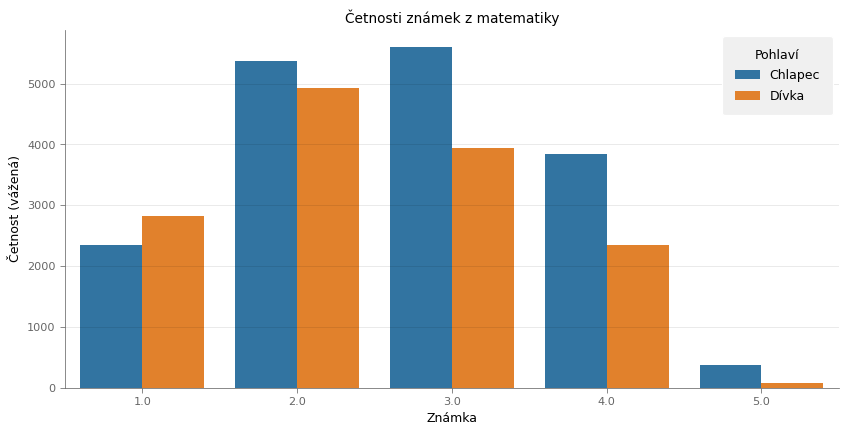

In [523]:
foo = df.groupby(['gr_matematika', 'girl'])['W_FSTUWT'].sum().reset_index()
ax = sns.barplot(x='gr_matematika', y='W_FSTUWT', hue='girl', data=foo)
ax.set(xlabel='Známka', ylabel='Četnost (vážená)')
ax.set_title('Četnosti známek z matematiky')
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['Chlapec', 'Dívka'], title='Pohlaví')

In [524]:
ax.get_figure().savefig('output/prisnost-znamkovani/01-cetnost-znamek.png')
ax.get_figure().savefig('output/prisnost-znamkovani/01-cetnost-znamek.pdf')

In [28]:
foo

,gr_matematika,girl,W_FSTUWT
0,1.0,0.0,2346.70889
1,1.0,1.0,2822.08362
2,2.0,0.0,5374.89499
3,2.0,1.0,4927.20088
4,3.0,0.0,5604.00630
5,3.0,1.0,3936.48293
6,4.0,0.0,3845.94832
7,4.0,1.0,2339.65236
8,5.0,0.0,367.39493
9,5.0,1.0,69.01168


In [512]:
%stata mi estimate, dots: reg math [pw = W_FSTUWT]


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Linear regression                               Number of obs     =      1,871
                                                Average RVI       =     0.6448
                                                Largest FMI       =     0.4121
                                                Complete DF       =       1870
                                                DF:     min       =      55.69
                                                        avg       =      55.69
DF adjustment:   Small sample                           max       =      55.69
                                                F(   0,      .)   =          .
Within VCE type:       Robust                   Prob > F          =          .

------------------------------------------------------------------------------
        math | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
------------

In [531]:
%stata mi estimate, dots: reg math ibn.gr_matematika#ibn.girl [pw = W_FSTUWT], noconstant


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Linear regression                               Number of obs     =      1,871
                                                Average RVI       =     0.3635
                                                Largest FMI       =     0.4514
                                                Complete DF       =       1861
DF adjustment:   Small sample                   DF:     min       =      46.75
                                                        avg       =     153.30
                                                        max       =     274.97
Model F test:       Equal FMI                   F(  10,  717.1)   =    5804.36
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
        math | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
------------

In [532]:
er = stata.get_ereturn()
coefs = er['e(b_mi)']
std_errs = np.sqrt(np.diag(er['e(V_mi)']))
dfr = er['e(df_r)']
foo = pd.DataFrame({'coef': coefs[0], 'se': std_errs})

foo['lc'] = foo['coef'] + scipy.stats.t.ppf(0.025, dfr) * foo['se']
foo['uc'] = foo['coef'] + scipy.stats.t.ppf(0.975, dfr) * foo['se']
foo['gr_matematika'] = foo.index // 2 + 1
foo['girl'] = foo.index % 2
foo['gr_matematika_dodged'] = foo['gr_matematika'] - 0.1 + 0.2 * foo['girl']
foo

,coef,se,lc,uc,gr_matematika,girl,gr_matematika_dodged
0,544.009517,8.245125,527.838851,560.180182,1,0,0.9
1,534.864422,7.018233,521.099987,548.628858,1,1,1.1
2,518.772500,4.627405,509.697051,527.847950,2,0,1.9
3,493.235957,5.009285,483.411550,503.060364,2,1,2.1
4,462.258734,4.733065,452.976060,471.541408,3,0,2.9
5,441.979536,5.406247,431.376591,452.582481,3,1,3.1
6,432.997833,5.416875,422.374043,443.621623,4,0,3.9
7,405.725684,6.772069,392.444033,419.007334,4,1,4.1
8,411.850788,21.810530,369.075116,454.626461,5,0,4.9
9,378.407758,38.720476,302.467629,454.347886,5,1,5.1


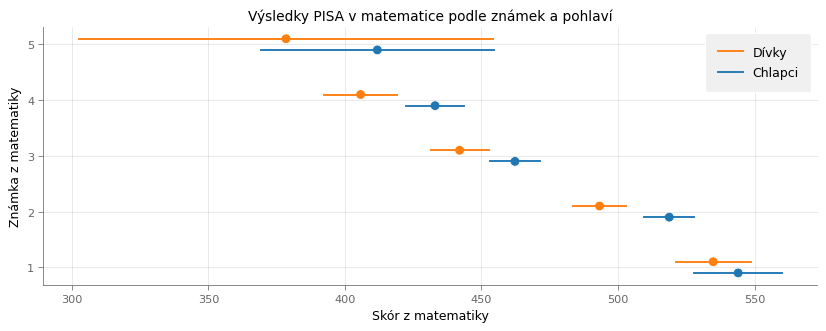

In [533]:
cur_palette = sns.color_palette(n_colors=2)

fig, ax = plt.subplots(figsize=(10, 3.6))
sns.scatterplot(x='coef', y='gr_matematika_dodged', data=foo, hue='girl', palette=cur_palette, legend=False, s=60)
for i in range(10):
    plt.plot(foo.loc[i, ['lc', 'uc']], [foo.loc[i, 'gr_matematika_dodged'], foo.loc[i, 'gr_matematika_dodged']], color=cur_palette[i % 2], lw=1.5)
ax.set(xlabel='Skór z matematiky', ylabel='Známka z matematiky', title='Výsledky PISA v matematice podle známek a pohlaví')

plt.legend(ax.lines[1::-1], ['Dívky', 'Chlapci'])

None

In [534]:
ax.get_figure().savefig('output/prisnost-znamkovani/03-prumerne-skory-pohlavi.png')
ax.get_figure().savefig('output/prisnost-znamkovani/03-prumerne-skory-pohlavi.pdf')

### Lineplot

In [595]:
%stata mi estimate, dots: reg math ibn.gr_matematika [pw = W_FSTUWT], noconstant


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Linear regression                               Number of obs     =      1,871
                                                Average RVI       =     0.3680
                                                Largest FMI       =     0.3540
                                                Complete DF       =       1866
DF adjustment:   Small sample                   DF:     min       =      74.23
                                                        avg       =     129.92
                                                        max       =     233.80
Model F test:       Equal FMI                   F(   5,  413.2)   =   11142.30
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
        math | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
------------

In [596]:
er = stata.get_ereturn()
b_mi = er['e(b_mi)']
V_mi = er['e(V_mi)']
dfr = er['e(df_r_mi)']
coefs = b_mi[0]
std_errs = np.sqrt(np.diag(V_mi))

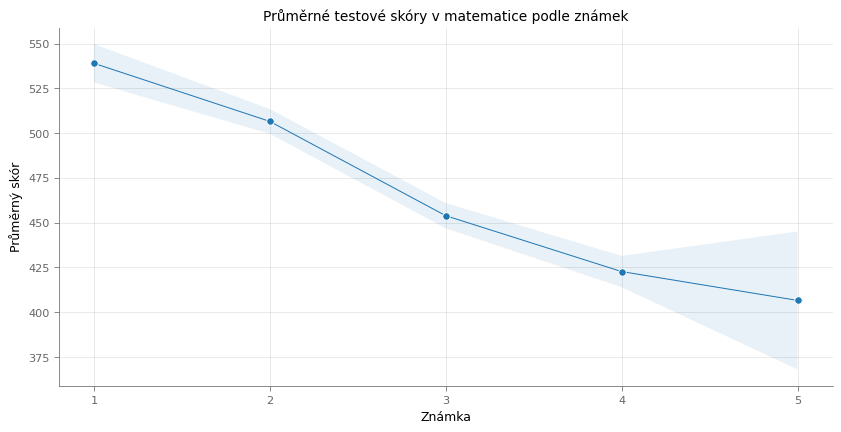

In [601]:
foo = pd.DataFrame({'grade': range(1, 6), 'coef': coefs, 'se': std_errs})

foo['lower'] = foo['coef'] + scipy.stats.t.ppf(0.025, dfr) * foo['se']
foo['upper'] = foo['coef'] + scipy.stats.t.ppf(0.975, dfr) * foo['se']

fig, ax = plt.subplots()
sns.lineplot(x='grade', y='coef', data=foo, marker='o')
plt.fill_between(foo['grade'], foo['lower'], foo['upper'], alpha=0.1)
ax.set(xlabel='Známka', ylabel='Průměrný skór')
ax.set_title('Průměrné testové skóry v matematice podle známek')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1.00))

In [602]:
ax.get_figure().savefig('output/prisnost-znamkovani/02-prumerne-skory.png')
ax.get_figure().savefig('output/prisnost-znamkovani/02-prumerne-skory.pdf')

In [49]:
foo

,grade,mean,lower,upper
0,1,539.016432,528.129328,549.903535
1,2,506.559095,499.521348,513.596841
2,3,453.891373,446.732171,461.050575
3,4,422.682368,413.806029,431.558707
4,5,406.562235,367.379416,445.745054


### Boxplots

In [536]:
boxplots = []

bxp_def = {
    'med': 0.5,
    'q1': 0.25,
    'q3': 0.75,
    'whislo': 0.05,
    'whishi': 0.95
}


for gr in range(1, 6):
    print(f'running {gr}')
    inner = {}
    inner['label'] = gr
    inner['fliers'] = []
    if gr < 5:
        cmd = 'qreg math [pw = W_FSTUWT]'
    else:
        cmd = 'bsqreg math'
    for lbl, q in bxp_def.items():        
        stata.run(f'''
            preserve
            keep if gr_matematika == {gr}
            mi estimate, dots: {cmd}, q({q})
            restore
        ''', quietly=True)
        inner[lbl] = stata.get_ereturn()['e(b_mi)'][0][0]
    boxplots.append(inner)

running 1





running 2





running 3





running 4





running 5







[Text(0.5, 1.0, 'Testové skóry v matematice podle známek'),
 Text(0.5, 0, 'Testový skór'),
 Text(0, 0.5, 'Známka')]

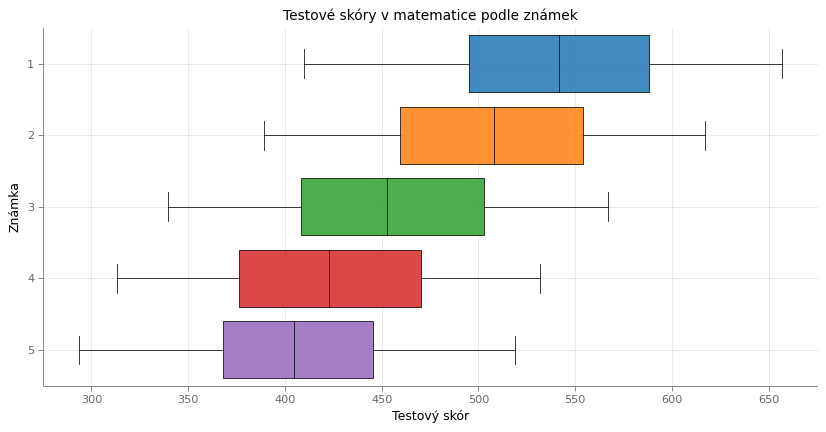

In [539]:
fig, ax = plt.subplots()

props = dict(linewidth=0.6, color='black')
pal = sns.color_palette(n_colors=5)

boxes = ax.bxp(boxplots, vert=False, positions=range(6, 1, -1), widths=0.8, patch_artist=True, medianprops=props, boxprops=dict(linewidth=0.6, edgecolor='black'), whiskerprops=props, capprops=props)
for i, bx in enumerate(boxes['boxes']):
    bx.set_facecolor([*pal[i], 0.85])
None

ax.set(title='Testové skóry v matematice podle známek', xlabel='Testový skór', ylabel='Známka')

In [540]:
ax.get_figure().savefig('output/prisnost-znamkovani/04-prumerne-skory-boxploty.png')
ax.get_figure().savefig('output/prisnost-znamkovani/04-prumerne-skory-boxploty.pdf')

In [24]:
pd.DataFrame(boxplots).drop(columns=['fliers']).rename(columns={'label': 'grade'})

,grade,med,q1,q3,whislo,whishi
0,1,541.836609,495.014703,588.191992,409.629999,657.039392
1,2,508.096695,459.597101,554.233197,389.074396,616.928802
2,3,452.747098,408.117203,503.108902,339.710901,567.076697
3,4,422.600204,376.473300,470.155600,313.184003,531.917596
4,5,404.865701,367.994797,445.333698,293.413599,519.075894


## Model a přísnost jednotlivých škol

In [50]:
%stata mi estimate, dots: mixed gr_matematika mathz girl ESCSz [pw = W_FSTUWT] || CNTSCHID: , pweight (W_SCHGRNRABWT) pwscale(size)


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Mixed-effects regression                        Number of obs     =      1,871

Group variable: CNTSCHID                        Number of groups  =        128
                                                Obs per group:
                                                              min =          1
                                                              avg =       14.6
                                                              max =         34
                                                Average RVI       =     0.1639
                                                Largest FMI       =     0.2829
DF adjustment:   Large sample                   DF:     min       =     122.32
                                                        avg       =   1,301.00
                                                        max       =   4,324.62
Model F test:       Equal FM

In [53]:
coefs = stata.get_ereturn()['e(b_mi)'][0]

In [65]:
coefs  # 5th and 6th are logs of estimated std devs (why logs?)

array([-0.50675392, -0.33512066, -0.15307308,  2.70381206, -1.47251757,
       -0.18827643])

In [58]:
df.head()

,CNTSTUID,CNTSCHID,CNTRYID,STRATUM,STRATUMID_rec,ST001D01T,ST003D02T,ST003D03T,ST004D01T,ST005Q01TA,...,_2_mathz,_3_mathz,_4_mathz,_5_mathz,_6_mathz,_7_mathz,_8_mathz,_9_mathz,_10_mathz,ESCSz
0,20301012,20300002,203,CZE0606,1,9,7,2002,1,1.0,...,0.784214,0.597992,0.899269,0.960669,0.651922,0.654166,0.283201,0.611885,0.783640,-0.840526
1,20300521,20300002,203,CZE0606,1,9,10,2002,1,1.0,...,0.308114,0.022139,0.536961,0.504654,0.113840,0.622679,-0.371601,-0.200786,-0.017800,1.629721
2,20301159,20300002,203,CZE0606,1,9,11,2002,1,2.0,...,-0.784395,-0.422394,-0.135456,-0.169120,0.009732,-0.082404,-0.871967,-0.650562,-0.268369,0.040614
3,20306750,20300002,203,CZE0606,1,9,6,2002,2,4.0,...,1.056056,-0.131708,0.498585,-0.222707,1.123492,0.637712,0.049509,0.735179,-0.638980,0.221304
4,20304622,20300002,203,CZE0606,1,9,5,2002,2,2.0,...,-0.386107,-0.079972,-0.199261,-0.375973,0.225695,0.189687,-0.723216,-1.133832,-0.963760,0.344877


In [121]:
for i in range(1,11):
    df[f'PV{i}MATHz'] = (df[f'PV{i}MATH'] - df[f'PV{i}MATH'].mean()) / df[f'PV{i}MATH'].std()
    
df['MATH_MEAN'] = np.mean(df[[f'PV{i}MATH' for i in range(1,11)]], axis=1)
df['MATH_Z'] = np.mean(df[[f'PV{i}MATHz' for i in range(1,11)]], axis=1)

In [158]:
df['gr_matematika_pred'] = coefs[3] + coefs[1] * df['girl'] + coefs[0] * df['MATH_Z'] + coefs[2] * df['ESCSz']
#df['gr_matematika_pred'] = 2.703638 - .3372834 * df['girl'] - .5079904 * df['MATH_Z'] - .1478415 * df['ESCSz']
df['gr_matematika_resid'] = df['gr_matematika'] - df['gr_matematika_pred']

In [173]:
n_bins = 4

# ať to můžu pouštět opakovaně
df = df.drop(columns=['prisnost', 'prisnost_bin'], errors='ignore')

sch_resid = df.groupby('CNTSCHID')[['gr_matematika_resid', 'W_SCHGRNRABWT', 'W_FSTUWT']]\
    .apply(nanaverage, weights='W_FSTUWT')\
    .rename(columns={'gr_matematika_resid': 'prisnost'})\
    .reset_index()

dsw = DescrStatsW(sch_resid['prisnost'], weights=sch_resid['W_SCHGRNRABWT'])
qs = dsw.quantile(np.arange(1, n_bins) / n_bins)
sch_resid['prisnost_bin'] = pd.cut(sch_resid['prisnost'], [-np.inf] + list(qs) + [np.inf], labels=False)

# hack to flatten the middle two --> this is the best I think - přísné, shovívavé, neutrální
sch_resid['prisnost_bin'] = np.round(2 * sch_resid['prisnost_bin'] / 3)

df = pd.merge(df, sch_resid.drop(columns=['W_SCHGRNRABWT']))

### Charakteristiky skupin přísnosti

In [425]:
# ok, this looks pretty sensible
tot_w = sch_resid['W_SCHGRNRABWT'].sum()
foo = sch_resid.sort_values('prisnost')
foo['cum_w'] = foo['W_SCHGRNRABWT'].cumsum()
foo['ratio_w'] = foo['cum_w'] / tot_w
foo.to_csv('temp/sch_resid.csv')

In [244]:
# these are not equal by most measures as school weights differ from number of schools or students
sch_resid['prisnost_bin'].value_counts()

1.0    73
0.0    33
2.0    22
Name: prisnost_bin, dtype: int64

In [230]:
df['prisnost_bin'].value_counts()

1.0    1174
0.0     478
2.0     219
Name: prisnost_bin, dtype: int64

In [427]:
sch_resid.groupby('prisnost_bin')[['prisnost', 'W_SCHGRNRABWT']].apply(nanaverage, weights='W_SCHGRNRABWT')

,prisnost
prisnost_bin,
0.0,-0.545792
1.0,0.027707
2.0,0.539074


### Distribuce přísnosti

/mnt/d/projects/idea/code/venv/lib/python3.10/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


[Text(0.5, 0, 'Přísnost známkování'),
 Text(0, 0.5, 'Vážená četnost'),
 Text(0.5, 1.0, 'Školy podle přísnosti')]

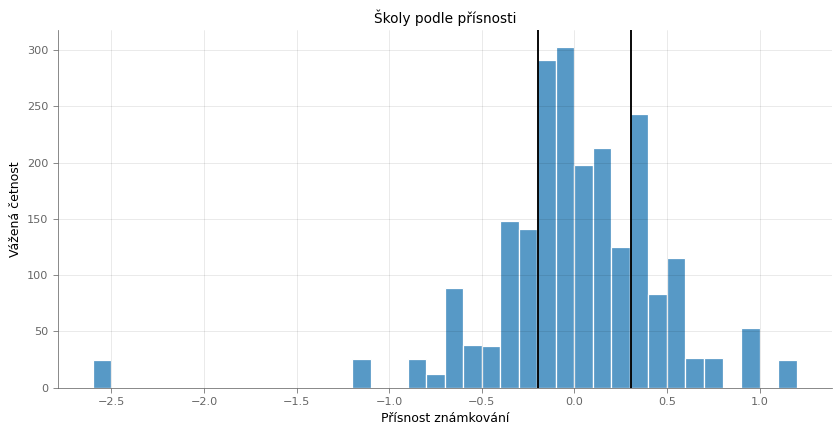

In [549]:
fig, ax = plt.subplots()
bins = np.arange(-2.6, 1.3, step=0.1)
sns.histplot(x='prisnost', weights='W_SCHGRNRABWT', data=sch_resid, bins=bins, edgecolor='white')
ax.axvline(qs[0.25], color='black', lw=1.5)
ax.axvline(qs[0.75], color='black', lw=1.5)
ax.set(xlabel='Přísnost známkování', ylabel='Vážená četnost', title='Školy podle přísnosti')

In [550]:
fig.savefig('output/prisnost-znamkovani/05-rozlozeni-prisnosti.png')
fig.savefig('output/prisnost-znamkovani/05-rozlozeni-prisnosti.pdf')

[Text(0.5, 0, 'Známka'),
 Text(0, 0.5, 'Průměrný skór'),
 Text(0.5, 1.0, 'Průměrné testové skóry z matematiky podle známek a přísnosti škol')]

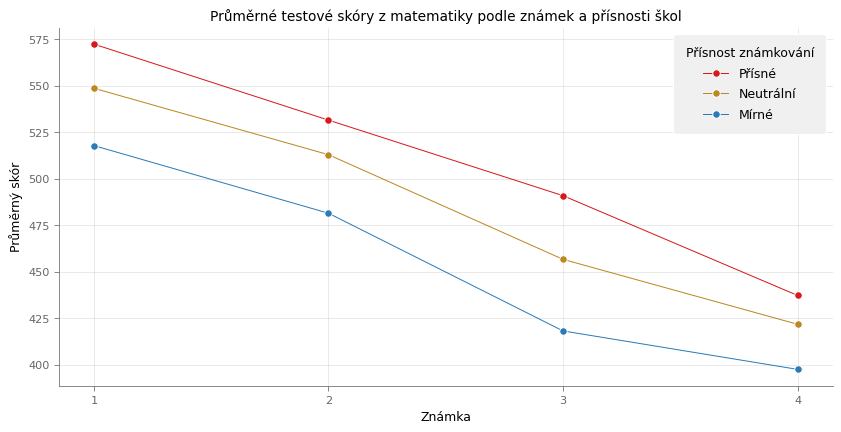

In [583]:
# df.groupby(['gr_matematika', 'SCH_BIN', 'ST225Q06HA'])['CNTSTUID'].count()
prisnost_pal = ['#d7191c', '#bb8822', '#2c7bb6']
prisnost_order = [2, 1, 0]

foo = df.groupby(['gr_matematika', 'prisnost_bin'])[['MATH_MEAN', 'ST225Q06HA', 'BSMJ', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
foo['prisnost_group'] = pd.Categorical(foo['prisnost_bin'])
foo = foo[foo['gr_matematika'] != 5]
foo['gr_matematika'] = foo['gr_matematika'].apply(lambda x: f'{x:.0g}')
ax = sns.lineplot(x='gr_matematika', y='MATH_MEAN', data=foo, hue='prisnost_group', marker='o', palette=prisnost_pal, hue_order=prisnost_order)
ax.legend(ax.lines[:3], ('Přísné', 'Neutrální', 'Mírné'), title='Přísnost známkování')
ax.set(xlabel='Známka', ylabel='Průměrný skór', title='Průměrné testové skóry z matematiky podle známek a přísnosti škol')

In [557]:
ax.get_figure().savefig('output/prisnost-znamkovani/07-skory-podle-znamek-a-prisnosti.png')
ax.get_figure().savefig('output/prisnost-znamkovani/07-skory-podle-znamek-a-prisnosti.pdf')

In [196]:
ax.lines

<Axes.ArtistList of 6 lines>

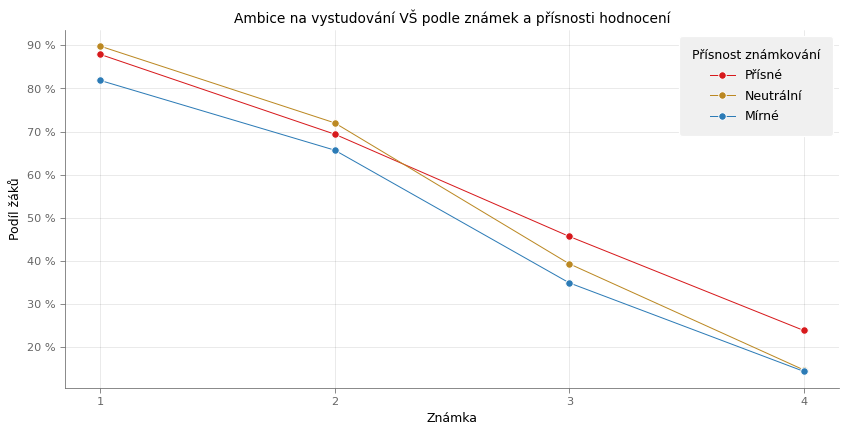

In [588]:
foo['ST225Q06HAx100'] = 100 * foo['ST225Q06HA']
ax = sns.lineplot(x='gr_matematika', y='ST225Q06HAx100', data=foo, hue='prisnost_group', marker='o', palette=prisnost_pal, hue_order=prisnost_order)
ax.legend(ax.lines[:3], ('Přísné', 'Neutrální', 'Mírné'), title='Přísnost známkování')
ax.set(title='Ambice na vystudování VŠ podle známek a přísnosti hodnocení', xlabel='Známka', ylabel='Podíl žáků')
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0, symbol=' %'))

In [589]:
ax.get_figure().savefig('output/prisnost-znamkovani/10-ambice-vs-znamky-prisnost.png')
ax.get_figure().savefig('output/prisnost-znamkovani/10-ambice-vs-znamky-prisnost.pdf')

[Text(0.5, 1.0, 'Očekávaný socioekonomický status zaměstnání ve 30 letech'),
 Text(0.5, 0, 'Známka'),
 Text(0, 0.5, 'Status zaměstnání')]

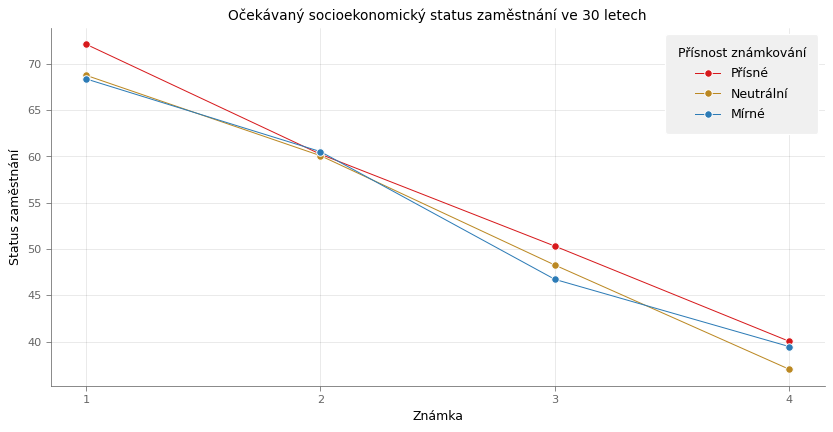

In [591]:
ax = sns.lineplot(x='gr_matematika', y='BSMJ', data=foo, hue='prisnost_group', marker='o', palette=prisnost_pal, hue_order=prisnost_order)
ax.legend(ax.lines[:3], ('Přísné', 'Neutrální', 'Mírné'), title='Přísnost známkování')
ax.set(title='Očekávaný socioekonomický status zaměstnání ve 30 letech', xlabel='Známka', ylabel='Status zaměstnání')

In [592]:
ax.get_figure().savefig('output/prisnost-znamkovani/11-ses-zamestnani-vs-znamky-prisnost.png')
ax.get_figure().savefig('output/prisnost-znamkovani/11-ses-zamestnani-vs-znamky-prisnost.pdf')

[Text(0.5, 0, 'Známka'), Text(0, 0.5, 'Relativní četnost')]

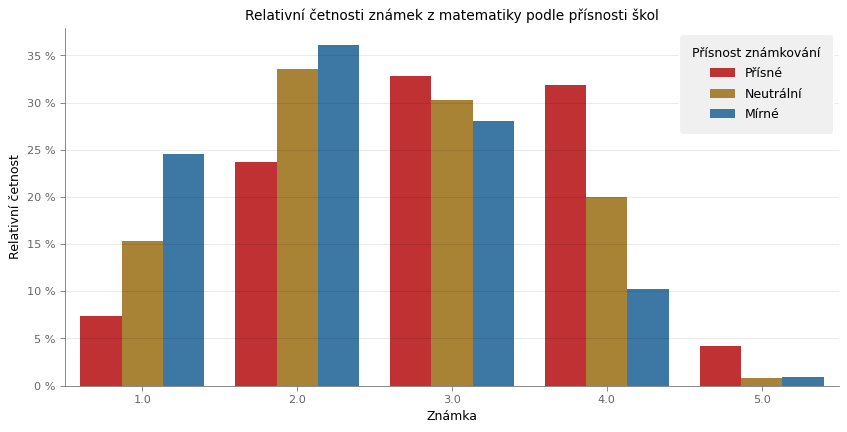

In [551]:
foo = df.groupby(['gr_matematika', 'prisnost_bin'])['W_FSTUWT'].sum().reset_index()
foo = pd.merge(foo, foo.groupby('prisnost_bin')['W_FSTUWT'].sum().rename('W_FSTUWT_TOTAL').reset_index())
foo['prisnost_group'] = pd.Categorical(foo['prisnost_bin'])
foo['rel_weight'] = 100 * foo['W_FSTUWT'] / foo['W_FSTUWT_TOTAL']
ax = sns.barplot(x='gr_matematika', y='rel_weight', hue='prisnost_group', data=foo, palette=prisnost_pal, hue_order=prisnost_order)
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0, symbol=' %'))
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ('Přísné', 'Neutrální', 'Mírné'), title='Přísnost známkování')
ax.set_title('Relativní četnosti známek z matematiky podle přísnosti škol')
ax.set(xlabel='Známka', ylabel='Relativní četnost')

In [552]:
ax.get_figure().savefig('output/prisnost-znamkovani/06-cetnosti-znamek-podle-prisnosti.png')
ax.get_figure().savefig('output/prisnost-znamkovani/06-cetnosti-znamek-podle-prisnosti.pdf')

In [554]:
foo

,gr_matematika,prisnost_bin,W_FSTUWT,W_FSTUWT_TOTAL,prisnost_group,rel_weight
0,1.0,0.0,1911.69239,7773.25666,0.0,24.593198
1,2.0,0.0,2807.90492,7773.25666,0.0,36.122632
2,3.0,0.0,2180.27414,7773.25666,0.0,28.048400
3,4.0,0.0,799.33475,7773.25666,0.0,10.283139
4,5.0,0.0,74.05046,7773.25666,0.0,0.952631
5,1.0,1.0,2877.69266,18729.71621,1.0,15.364315
6,2.0,1.0,6278.84664,18729.71621,1.0,33.523448
7,3.0,1.0,5676.76828,18729.71621,1.0,30.308886
8,4.0,1.0,3751.03898,18729.71621,1.0,20.027207
9,5.0,1.0,145.36965,18729.71621,1.0,0.776144


In [544]:
%stata mi estimate, dots: reg math ibn.prisnost_bin [pw = W_FSTUWT], noconstant


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Linear regression                               Number of obs     =      1,871
                                                Average RVI       =     0.3347
                                                Largest FMI       =     0.3928
                                                Complete DF       =       1868
DF adjustment:   Small sample                   DF:     min       =      61.03
                                                        avg       =     201.87
                                                        max       =     331.46
Model F test:       Equal FMI                   F(   3,  279.2)   =   14751.89
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
        math | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
------------

In [545]:
er = stata.get_ereturn()
coefs = er['e(b_mi)']
std_errs = np.sqrt(np.diag(er['e(V_mi)']))
dfr = er['e(df_r)']
foo = pd.DataFrame({'coef': coefs[0], 'se': std_errs})

foo['lc'] = foo['coef'] + scipy.stats.t.ppf(0.025, dfr) * foo['se']
foo['uc'] = foo['coef'] + scipy.stats.t.ppf(0.975, dfr) * foo['se']
foo['prisnost_bin'] = foo.index
foo['label'] = foo['prisnost_bin'].apply(lambda x: blbls[int(x)])
foo = foo.sort_values('prisnost_bin', ascending=False).reset_index(drop=True)
foo

,coef,se,lc,uc,prisnost_bin,label
0,485.995394,6.218971,473.798531,498.192257,2,Přísné
1,482.443071,3.087357,476.388040,488.498102,1,Neutrální
2,462.820505,4.526388,453.943197,471.697814,0,Mírné


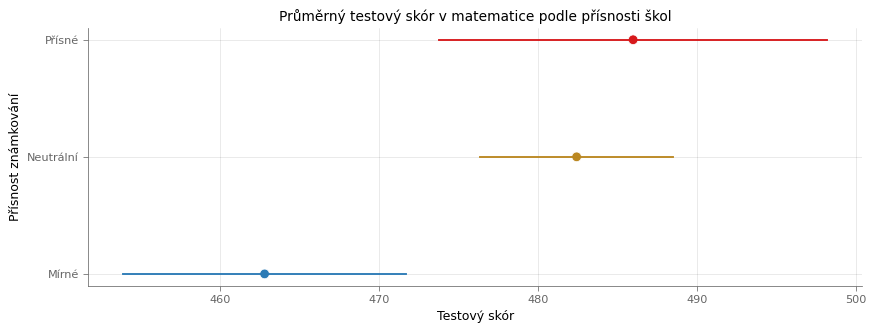

In [547]:
fig, ax = plt.subplots(figsize=(10, 3.6))
sns.scatterplot(x='coef', y='label', data=foo, hue='prisnost_bin', hue_order=[2, 1, 0], palette=prisnost_pal, legend=False, s=60)
for i in range(3):
    plt.plot(foo.loc[i, ['lc', 'uc']], [i, i], color=prisnost_pal[i], lw=1.5)
ax.set(xlabel='Testový skór', ylabel='Přísnost známkování', title='Průměrný testový skór v matematice podle přísnosti škol')
None

### Boxploty - skóry jednotlivých skupin

In [262]:
df.shape

(1871, 769)

In [ ]:
# když pošlu df do staty, nebudu mít MIs...
# stata.pdataframe_to_data(df, Force=True)

In [266]:
sch_resid

,CNTSCHID,prisnost,W_SCHGRNRABWT,prisnost_bin
0,20300002,0.374923,24.29682,2.0
1,20300005,-0.003525,26.19107,1.0
2,20300006,-0.367006,21.93036,0.0
3,20300010,0.014609,22.01021,1.0
4,20300018,0.192193,15.37976,1.0
...,...,...,...,...
123,20300322,-0.729091,12.42679,0.0
124,20300323,0.560320,13.33673,2.0
125,20300326,-0.168939,9.97579,1.0
126,20300329,-0.017580,13.34809,1.0


In [267]:
%stata count

  1,871


In [268]:
stata.pdataframe_to_frame(sch_resid.drop(columns=['W_SCHGRNRABWT']), 'schools')

In [269]:
%stata frame dir

* default  1871 x 753; St09833.000005
* schools  128 x 3

Note: Frames marked with * contain unsaved data.


In [271]:
%stata frlink m:1 CNTSCHID, frame(schools CNTSCHID)

  (all observations in frame default matched)


In [274]:
%stata frget(prisnost prisnost_bin), from(schools)

  (2 variables copied from linked frame)


In [275]:
%stata tab prisnost_bin


prisnost_bi |
          n |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |        478       25.55       25.55
          1 |      1,174       62.75       88.30
          2 |        219       11.70      100.00
------------+-----------------------------------
      Total |      1,871      100.00


In [277]:
%stata bysort prisnost_bin: sum W_FSTUWT


-------------------------------------------------------------------------------
-> prisnost_bin = 0

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
    W_FSTUWT |        478    16.26204    5.412743   11.13511   28.17806

-------------------------------------------------------------------------------
-> prisnost_bin = 1

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
    W_FSTUWT |      1,174    15.95376    4.972928   10.49324   29.83266

-------------------------------------------------------------------------------
-> prisnost_bin = 2

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
    W_FSTUWT |        219    23.42654    10.62025   10.35272   77.80351



In [278]:
boxplots = []

bxp_def = {
    'med': 0.5,
    'q1': 0.25,
    'q3': 0.75,
    'whislo': 0.05,
    'whishi': 0.95
}

blbls = ['Mírné', 'Neutrální', 'Přísné']

for b, blbl in enumerate(blbls):
    print(f'running {b} -- {blbl}')
    inner = {}
    inner['label'] = blbl
    inner['fliers'] = []
    cmd = 'qreg math [pw = W_FSTUWT]'
    for lbl, q in bxp_def.items():        
        stata.run(f'''
            preserve
            keep if prisnost_bin == {b}
            mi estimate, dots: {cmd}, q({q})
            restore
        ''', quietly=True)
        inner[lbl] = stata.get_ereturn()['e(b_mi)'][0][0]
    boxplots.append(inner)

running 0 -- Mírné





running 1 -- Neutrální





running 2 -- Přísné







In [386]:
plt.rcParams['figure.figsize'] = 10, 3.6

[Text(0.5, 0, 'Skór z matematiky'),
 Text(0, 0.5, 'Přísnost známkování'),
 Text(0.5, 1.0, 'Testové skóry podle přísnosti škol')]

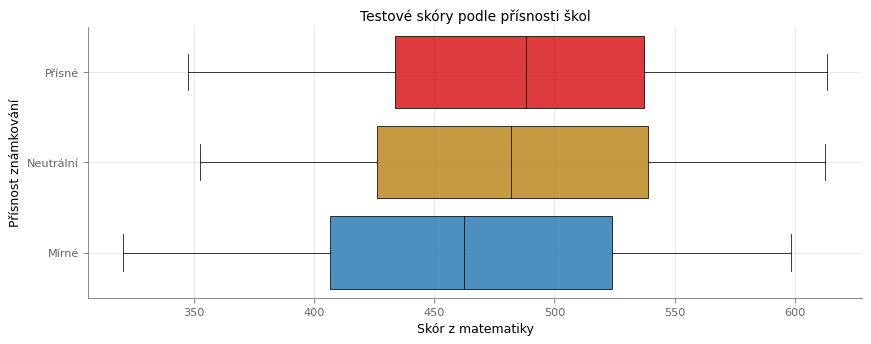

In [387]:
fig, ax = plt.subplots()

props = dict(linewidth=0.6, color='black')
pal = prisnost_pal[::-1]

boxes = ax.bxp(boxplots, vert=False, widths=0.8, patch_artist=True, medianprops=props, boxprops=dict(linewidth=0.6, edgecolor='black'), whiskerprops=props, capprops=props)
for i, bx in enumerate(boxes['boxes']):
    col = tuple(int(pal[i][j:j+2], 16) / 255 for j in (1, 3, 5))
    bx.set_facecolor([*col, 0.85])
None

ax.set(xlabel='Skór z matematiky', ylabel='Přísnost známkování', title='Testové skóry podle přísnosti škol')

In [288]:
pd.DataFrame(boxplots).drop(columns=['fliers']).rename(columns={'label': 'prisnost'})

,prisnost,med,q1,q3,whislo,whishi
0,Mírné,462.535101,406.552200,523.992096,320.647800,598.668091
1,Neutrální,481.967999,426.102597,538.961700,352.366196,612.644501
2,Přísné,487.995700,433.504700,537.122504,347.647601,613.470905


### Boxploty pro aspirace podle přísnosti

In [312]:
def get_bx_data(frame, x, weights=None):
    if weights is not None:        
        dsw = DescrStatsW(frame[x], weights=frame[weights])
    else:
        dsw = DescrStatsW(frame[x])
    res = pd.Series({k: dsw.quantile(v).values[0] for k, v in bxp_def.items()})
    res['fliers'] = []
    return res

bx_bsmj = df.groupby('prisnost_bin').apply(lambda fr: get_bx_data(fr, 'BSMJ', weights='W_FSTUWT')).reset_index()
bx_bsmj['label'] = bx_bsmj['prisnost_bin'].apply(lambda x: blbls[int(x)])

In [315]:
bx_bsmj

,prisnost_bin,med,q1,q3,whislo,whishi,fliers,label
0,0.0,55.25,36.35,76.65,24.53,88.31,[],Mírné
1,1.0,51.50,31.08,74.66,23.57,86.72,[],Neutrální
2,2.0,47.42,30.78,73.71,24.53,83.50,[],Přísné


[Text(0.5, 0, 'BSMJ'),
 Text(0, 0.5, 'Přísnost známkování'),
 Text(0.5, 1.0, 'Očekávaná kvalifikace zaměstnání ve 30 letech')]

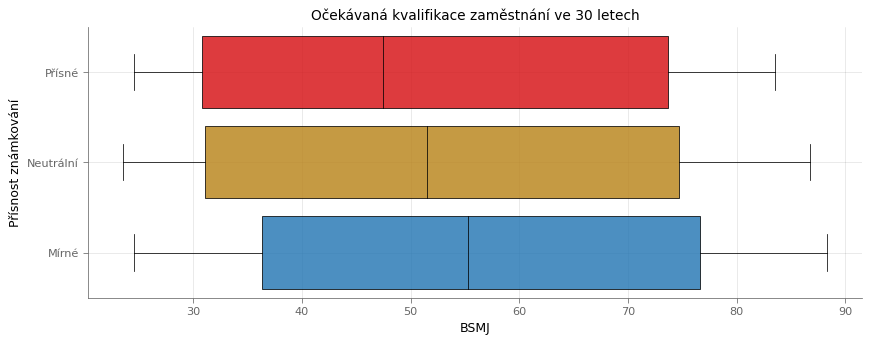

In [388]:
fig, ax = plt.subplots()

props = dict(linewidth=0.6, color='black')
pal = prisnost_pal[::-1]
bx_bsmj_data = [dict(r) for _, r in bx_bsmj.iterrows()]

boxes = ax.bxp(bx_bsmj_data, vert=False, widths=0.8, patch_artist=True, medianprops=props, boxprops=dict(linewidth=0.6, edgecolor='black'), whiskerprops=props, capprops=props)
for i, bx in enumerate(boxes['boxes']):
    col = tuple(int(pal[i][j:j+2], 16) / 255 for j in (1, 3, 5))
    bx.set_facecolor([*col, 0.85])
None

ax.set(xlabel='BSMJ', ylabel='Přísnost známkování', title='Očekávaná kvalifikace zaměstnání ve 30 letech')

In [421]:
%stata reg BSMJ ibn.prisnost_bin [pw = W_FSTUWT], noconstant

(sum of wgt is 25,217.61132)

Linear regression                               Number of obs     =      1,481
                                                F(3, 1478)        =    2632.83
                                                Prob > F          =     0.0000
                                                R-squared         =     0.8549
                                                Root MSE          =     21.881

------------------------------------------------------------------------------
             |               Robust
        BSMJ | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
prisnost_bin |
          0  |    55.9091   1.172784    47.67   0.000      53.6086     58.2096
          1  |   52.68951   .7627074    69.08   0.000     51.19341    54.18562
          2  |   49.83751   1.705886    29.22   0.000     46.49129    53.18372
-------------------------------------------------

In [422]:
er = stata.get_ereturn()
coefs = er['e(b)']
std_errs = np.sqrt(np.diag(er['e(V)']))
dfr = er['e(df_r)']
foo = pd.DataFrame({'coef': coefs[0], 'se': std_errs})

In [423]:
foo['lc'] = foo['coef'] + scipy.stats.t.ppf(0.025, dfr) * foo['se']
foo['uc'] = foo['coef'] + scipy.stats.t.ppf(0.975, dfr) * foo['se']
foo['prisnost_bin'] = foo.index
foo['label'] = foo['prisnost_bin'].apply(lambda x: blbls[int(x)])
foo = foo.sort_values('prisnost_bin', ascending=False).reset_index(drop=True)
foo

,coef,se,lc,uc,prisnost_bin,label
0,49.837506,1.705886,46.491291,53.183722,2,Přísné
1,52.689511,0.762707,51.193407,54.185615,1,Neutrální
2,55.909097,1.172784,53.608599,58.209596,0,Mírné


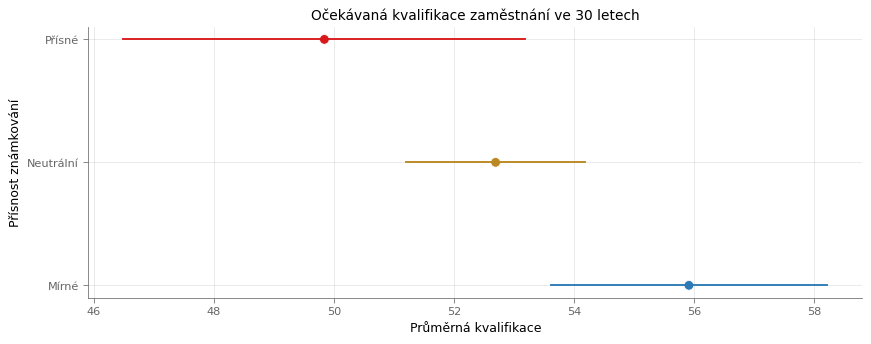

In [424]:
fig, ax = plt.subplots(figsize=(10, 3.6))
sns.scatterplot(x='coef', y='label', data=foo, hue='prisnost_bin', hue_order=[2, 1, 0], palette=prisnost_pal, legend=False, s=60)
for i in range(3):
    plt.plot(foo.loc[i, ['lc', 'uc']], [i, i], color=prisnost_pal[i], lw=1.5)
ax.set(xlabel='Průměrná kvalifikace', ylabel='Přísnost známkování', title='Očekávaná kvalifikace zaměstnání ve 30 letech')
None

In [429]:
%stata logit ST225Q06HA ibn.prisnost_bin [pw = W_FSTUWT], noconstant


Iteration 0:   log pseudolikelihood = -21926.592  
Iteration 1:   log pseudolikelihood = -21831.031  
Iteration 2:   log pseudolikelihood =  -21831.03  

Logistic regression                                     Number of obs =  1,871
                                                        Wald chi2(3)  =   9.78
Log pseudolikelihood = -21831.03                        Prob > chi2   = 0.0205

------------------------------------------------------------------------------
             |               Robust
  ST225Q06HA | Coefficient  std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
prisnost_bin |
          0  |   .2172455   .0974546     2.23   0.026      .026238    .4082531
          1  |   .1122369   .0613509     1.83   0.067    -.0080087    .2324825
          2  |  -.1792658   .1482568    -1.21   0.227    -.4698438    .1113123
------------------------------------------------------------------------------


In [430]:
er = stata.get_ereturn()
coefs = er['e(b)']
std_errs = np.sqrt(np.diag(er['e(V)']))

In [431]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

In [432]:
foo = pd.DataFrame({'coef': coefs[0], 'se': std_errs})

In [438]:
foo['prob'] = logistic(foo['coef']) * 100
foo['lp'] = logistic(foo['coef'] + scipy.stats.norm.ppf(0.025) * foo['se']) * 100
foo['up'] = logistic(foo['coef'] + scipy.stats.norm.ppf(0.975) * foo['se']) * 100

In [439]:
foo['prisnost_bin'] = foo.index
foo['label'] = foo['prisnost_bin'].apply(lambda x: blbls[int(x)])

In [440]:
foo = foo.sort_values('prisnost_bin', ascending=False).reset_index(drop=True)
foo

,coef,se,prob,lp,up,prisnost_bin,label
0,0.217246,0.097455,55.409878,50.655913,60.066892,2,Přísné
1,0.112237,0.061351,52.802980,49.799783,55.786025,1,Neutrální
2,-0.179266,0.148257,45.530319,38.465321,52.779937,0,Mírné


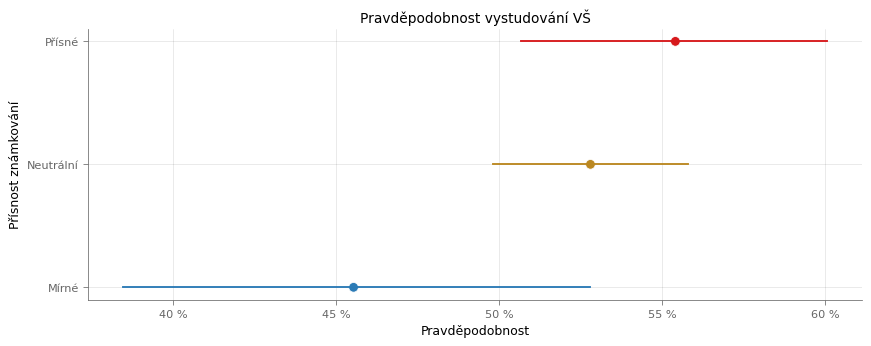

In [441]:
fig, ax = plt.subplots(figsize=(10, 3.6))
sns.scatterplot(x='prob', y='label', data=foo, hue='prisnost_bin', hue_order=[2, 1, 0], palette=prisnost_pal, legend=False, s=60)
for i in range(3):
    plt.plot(foo.loc[i, ['lp', 'up']], [i, i], color=prisnost_pal[i], lw=1.5)
ax.set(xlabel='Pravděpodobnost', ylabel='Přísnost známkování', title='Pravděpodobnost vystudování VŠ')
ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0, symbol=' %'))
None

In [329]:
df.groupby('prisnost_bin')[['ST225Q06HA', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT')

,ST225Q06HA
prisnost_bin,
0.0,0.554099
1.0,0.528030
2.0,0.455303


In [575]:
%stata mi estimate, dots: reg mathz [pw = W_FSTUWT]
mathz_mean = stata.get_ereturn()['e(b_mi)'][0][0]


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Linear regression                               Number of obs     =      1,871
                                                Average RVI       =     0.0870
                                                Largest FMI       =     0.0814
                                                Complete DF       =       1870
                                                DF:     min       =     773.16
                                                        avg       =     773.16
DF adjustment:   Small sample                           max       =     773.16
                                                F(   0,      .)   =          .
Within VCE type:       Robust                   Prob > F          =          .

------------------------------------------------------------------------------
       mathz | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
------------

In [576]:
%stata mi estimate, dots: logit ST225Q06HA mathz ib1.prisnost_bin [pw = W_FSTUWT]
coefs = stata.get_ereturn()['e(b_mi)'][0]


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Logistic regression                             Number of obs     =      1,871
                                                Average RVI       =     0.1129
                                                Largest FMI       =     0.2731
DF adjustment:   Large sample                   DF:     min       =     131.04
                                                        avg       =  12,020.94
                                                        max       =  26,362.42
Model F test:       Equal FMI                   F(   3, 1296.2)   =      71.18
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
  ST225Q06HA | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
       mathz

In [577]:
coefs

array([ 1.00927792,  0.3667813 ,  0.        , -0.4018891 ,  0.10826894])

In [579]:
# žáci z neutrálně známkujících škol s průměrným skórem (průměr je celkový)
logistic(coefs[4] + coefs[0] * mathz_mean)

0.521493820367907

In [581]:
# žáci z mírných škol s průměrným skórem 
logistic(coefs[4] + coefs[0] * mathz_mean + coefs[1])

0.6113070342441009

In [582]:
# žáci z přísných škol s průměrným skórem 
logistic(coefs[4] + coefs[0] * mathz_mean + coefs[3])

0.42168483281494756

In [580]:
%stata mi estimate, dots: reg math [pw = W_FSTUWT]


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Linear regression                               Number of obs     =      1,871
                                                Average RVI       =     0.6448
                                                Largest FMI       =     0.4121
                                                Complete DF       =       1870
                                                DF:     min       =      55.69
                                                        avg       =      55.69
DF adjustment:   Small sample                           max       =      55.69
                                                F(   0,      .)   =          .
Within VCE type:       Robust                   Prob > F          =          .

------------------------------------------------------------------------------
        math | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
------------

In [574]:
mathz_mean

-0.022036189215004394

In [513]:
%stata logit ST225Q06HA [pw = W_FSTUWT]


Iteration 0:   log pseudolikelihood =  -21894.15  
Iteration 1:   log pseudolikelihood =  -21894.15  

Logistic regression                                    Number of obs =   1,871
                                                       Wald chi2(0)  =       .
                                                       Prob > chi2   =       .
Log pseudolikelihood = -21894.15                       Pseudo R2     = -0.0000

------------------------------------------------------------------------------
             |               Robust
  ST225Q06HA | Coefficient  std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
       _cons |   .0906246   .0496753     1.82   0.068    -.0067372    .1879865
------------------------------------------------------------------------------


In [514]:
logistic(stata.get_ereturn()['e(b)'][0][0])

0.5226406662538349

In [515]:
nanaverage(df[['ST225Q06HA', 'W_FSTUWT']], weights='W_FSTUWT')

ST225Q06HA    0.522641
dtype: float64

In [613]:
%stata mi estimate, dots: logit ST225Q06HA mathz girl ESCSz [pw = W_FSTUWT]


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Logistic regression                             Number of obs     =      1,871
                                                Average RVI       =     0.1103
                                                Largest FMI       =     0.2403
DF adjustment:   Large sample                   DF:     min       =     168.19
                                                        avg       =   4,122.60
                                                        max       =  12,338.26
Model F test:       Equal FMI                   F(   3, 1321.0)   =      98.14
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
  ST225Q06HA | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
       mathz

In [614]:
%stata mi estimate, dots: logit ST225Q06HA mathz girl ESCSz_pos [pw = W_FSTUWT]
coefs = stata.get_ereturn()['e(b_mi)'][0]


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Logistic regression                             Number of obs     =      1,871
                                                Average RVI       =     0.1245
                                                Largest FMI       =     0.2619
DF adjustment:   Large sample                   DF:     min       =     142.17
                                                        avg       =   4,103.97
                                                        max       =   9,467.82
Model F test:       Equal FMI                   F(   3, 1056.4)   =      94.67
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
  ST225Q06HA | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
       mathz

In [615]:
coefs

array([ 0.96583163,  1.00896179,  1.05412871, -0.75675765])

In [621]:
# chlapec, nízký SES
boy_low = logistic(coefs[3] + mathz_mean * coefs[0])
boy_low

0.31474227039762487

In [622]:
# dívka, nízký SES
girl_low = logistic(coefs[3] + mathz_mean * coefs[0] + coefs[1])
girl_low

0.5574750471256797

In [623]:
# chlapec, vysoký SES
boy_high = logistic(coefs[3] + mathz_mean * coefs[0] + coefs[2])
boy_high

0.5685868373538834

In [624]:
# dívka, vysoký SES
girl_high = logistic(coefs[3] + mathz_mean * coefs[0] + coefs[1] + coefs[2])
girl_high

0.7833081032638246

In [637]:
foo = pd.DataFrame({'ses': 2 * ['Nízký SES', 'Vysoký SES'], 'gender': 2 * ['Chlapec'] + 2 * ['Dívka'], 'uni': [boy_low, boy_high, girl_low, girl_high]})
foo['unix100'] = 100 * foo['uni']

[Text(0.5, 0, 'Pravděpodobnost'),
 Text(0, 0.5, 'Socioekonomický status'),
 Text(0.5, 1.0, 'Pravděpodobnost, že žák s průměrnou gramotností chce vystudovat VŠ')]

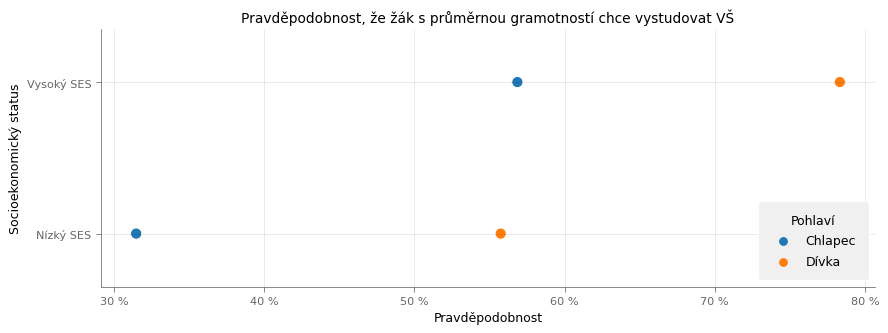

In [641]:
fig, ax = plt.subplots(figsize=(10, 3.6))
sns.scatterplot(x='unix100', y='ses', data=foo, hue='gender', s=80)
ymax, ymin = ax.get_ylim()
ax.set_ylim((ymin - 0.3, ymax + 0.3))
ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0, symbol=' %'))
plt.legend(loc='lower right', title='Pohlaví')
ax.set(xlabel='Pravděpodobnost', ylabel='Socioekonomický status', title='Pravděpodobnost, že žák s průměrnou gramotností chce vystudovat VŠ')

In [642]:
ax.get_figure().savefig('output/prisnost-znamkovani/12-ambice-vs-logit-gender-ses.png')
ax.get_figure().savefig('output/prisnost-znamkovani/12-ambice-vs-logit-gender-ses.pdf')

In [643]:
foo

,ses,gender,uni,unix100
0,Nízký SES,Chlapec,0.314742,31.474227
1,Vysoký SES,Chlapec,0.568587,56.858684
2,Nízký SES,Dívka,0.557475,55.747505
3,Vysoký SES,Dívka,0.783308,78.330810


In [644]:
%stata mi estimate, dots: logit ST225Q06HA mathz girl ESCSz_pos ib2.gr_matematika [pw = W_FSTUWT]


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Logistic regression                             Number of obs     =      1,871
                                                Average RVI       =     0.0521
                                                Largest FMI       =     0.2564
DF adjustment:   Large sample                   DF:     min       =     148.25
                                                        avg       =  79,299.32
                                                        max       = 274,756.85
Model F test:       Equal FMI                   F(   7,18153.0)   =      53.39
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
  ST225Q06HA | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
       mathz

In [625]:
2 * [0, 1]

[0, 1, 0, 1]

In [ ]:
logistic()

In [606]:
%stata gen ESCSz_pos = ESCSz > 0

In [608]:
%stata tab ESCSz_pos


  ESCSz_pos |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |      1,026       54.84       54.84
          1 |        845       45.16      100.00
------------+-----------------------------------
      Total |      1,871      100.00


### Známky vs vzdělávací a kariérní aspirace

In [559]:
%stata logit ST225Q06HA ibn.gr_matematika [pw = W_FSTUWT], noconstant


Iteration 0:   log pseudolikelihood = -21926.592  
Iteration 1:   log pseudolikelihood = -17670.453  
Iteration 2:   log pseudolikelihood = -17633.878  
Iteration 3:   log pseudolikelihood = -17633.329  
Iteration 4:   log pseudolikelihood = -17633.326  
Iteration 5:   log pseudolikelihood = -17633.326  

Logistic regression                                     Number of obs =  1,871
                                                        Wald chi2(5)  = 325.03
Log pseudolikelihood = -17633.326                       Prob > chi2   = 0.0000

------------------------------------------------------------------------------
             |               Robust
  ST225Q06HA | Coefficient  std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
gr_matemat~a |
          1  |   1.877243   .1762571    10.65   0.000     1.531786    2.222701
          2  |   .8460131   .0970277     8.72   0.000     .6558423    1.036184
        

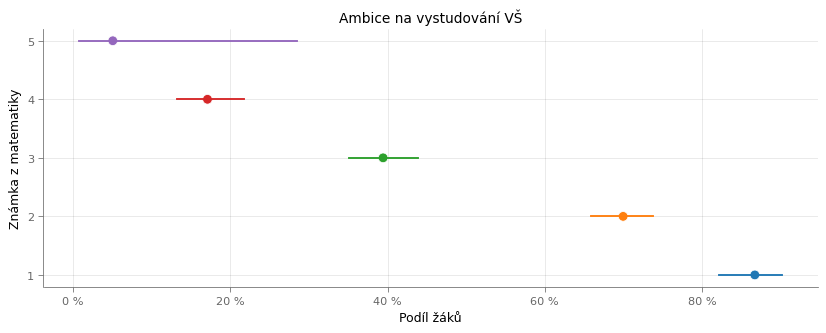

In [562]:
er = stata.get_ereturn()
coefs = er['e(b)']
std_errs = np.sqrt(np.diag(er['e(V)']))

foo = pd.DataFrame({'coef': coefs[0], 'se': std_errs})
foo['prob'] = logistic(foo['coef']) * 100
foo['lp'] = logistic(foo['coef'] + scipy.stats.norm.ppf(0.025) * foo['se']) * 100
foo['up'] = logistic(foo['coef'] + scipy.stats.norm.ppf(0.975) * foo['se']) * 100

foo['gr_matematika'] = foo.index + 1

cur_palette = sns.color_palette(n_colors=5)

fig, ax = plt.subplots(figsize=(10, 3.6))
sns.scatterplot(x='prob', y='gr_matematika', data=foo, hue='gr_matematika', legend=False, s=60, palette=cur_palette)
for i in range(5):
    plt.plot(foo.loc[i, ['lp', 'up']], [i + 1, i + 1], color=cur_palette[i], lw=1.5)
ax.set(xlabel='Podíl žáků', ylabel='Známka z matematiky', title='Ambice na vystudování VŠ')
ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0, symbol=' %'))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1.00))
None

In [563]:
ax.get_figure().savefig('output/prisnost-znamkovani/08-ambice-vs-znamky.png')
ax.get_figure().savefig('output/prisnost-znamkovani/08-ambice-vs-znamky.pdf')

In [564]:
foo

,coef,se,prob,lp,up,gr_matematika
0,1.877243,0.176257,86.729418,82.226746,90.226962,1
1,0.846013,0.097028,69.973014,65.832580,73.811303,2
2,-0.429079,0.094306,39.434628,35.116637,43.924129,3
3,-1.579311,0.152892,17.089304,13.250668,21.761017,4
4,-2.935317,1.027344,5.043510,0.704146,28.459945,5


In [565]:
%stata reg BSMJ ibn.gr_matematika [pw = W_FSTUWT], noconstant

(sum of wgt is 25,217.61132)

Linear regression                               Number of obs     =      1,481
                                                F(5, 1476)        =    2008.09
                                                Prob > F          =     0.0000
                                                R-squared         =     0.8877
                                                Root MSE          =     19.261

------------------------------------------------------------------------------
             |               Robust
        BSMJ | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
gr_matemat~a |
          1  |   68.90215   1.312535    52.50   0.000     66.32752    71.47678
          2  |   60.23293   .9914795    60.75   0.000     58.28807    62.17779
          3  |   48.26596   1.036237    46.58   0.000      46.2333    50.29861
          4  |    38.1224   1.031228    36.97   0

In [566]:
er = stata.get_ereturn()
coefs = er['e(b)']
std_errs = np.sqrt(np.diag(er['e(V)']))
dfr = er['e(df_r)']
foo = pd.DataFrame({'coef': coefs[0], 'se': std_errs})

foo['lc'] = foo['coef'] + scipy.stats.t.ppf(0.025, dfr) * foo['se']
foo['uc'] = foo['coef'] + scipy.stats.t.ppf(0.975, dfr) * foo['se']
foo['gr_matematika'] = foo.index + 1
foo

,coef,se,lc,uc,gr_matematika
0,68.902151,1.312535,66.327519,71.476783,1
1,60.232932,0.991479,58.288073,62.177791,2
2,48.265955,1.036237,46.233301,50.298609,3
3,38.122396,1.031228,36.099567,40.145225,4
4,38.186225,5.019542,28.340029,48.032421,5


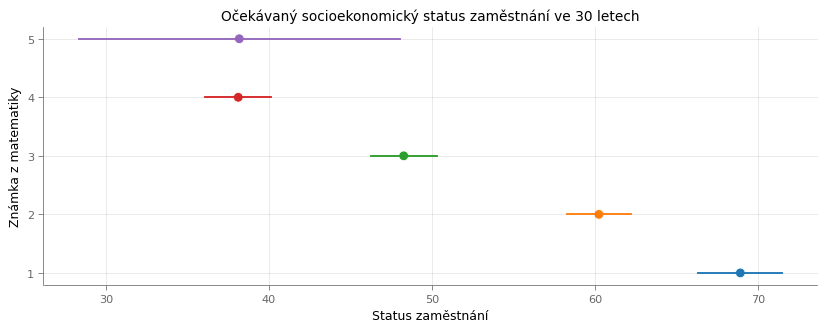

In [567]:
fig, ax = plt.subplots(figsize=(10, 3.6))
sns.scatterplot(x='coef', y='gr_matematika', data=foo, hue='gr_matematika', palette=cur_palette, legend=False, s=60)
for i in range(5):
    plt.plot(foo.loc[i, ['lc', 'uc']], [i + 1, i + 1], color=cur_palette[i], lw=1.5)
ax.set(xlabel='Status zaměstnání', ylabel='Známka z matematiky', title='Očekávaný socioekonomický status zaměstnání ve 30 letech')
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1.00))
None

In [568]:
ax.get_figure().savefig('output/prisnost-znamkovani/09-ses-zamestnani-vs-znamky.png')
ax.get_figure().savefig('output/prisnost-znamkovani/09-ses-zamestnani-vs-znamky.pdf')

### Logit model pro vystudování VŠ nebo regrese pro SBMJ

Testové skóry hrají roli, ale známky jsou důležitější.

In [390]:
%%stata
gen gr_cestina = ST800C02HA_CZ
gen gr_anglictina = ST800C03HA_CZ
gen gr_fyzika = ST800C04HA_CZ

recode gr_cestina 6=.
recode gr_anglictina 6=.
recode gr_fyzika 6=.

egen gr_cestina_z = std(gr_cestina)
egen gr_anglictina_z = std(gr_anglictina)
egen gr_fyzika_z = std(gr_fyzika)


. gen gr_cestina = ST800C02HA_CZ
(3 missing values generated)

. gen gr_anglictina = ST800C03HA_CZ
(7 missing values generated)

. gen gr_fyzika = ST800C04HA_CZ
(4 missing values generated)

. 
. recode gr_cestina 6=.
(0 changes made to gr_cestina)

. recode gr_anglictina 6=.
(2 changes made to gr_anglictina)

. recode gr_fyzika 6=.
(1 changes made to gr_fyzika)

. 
. egen gr_cestina_z = std(gr_cestina)
(3 missing values generated)

. egen gr_anglictina_z = std(gr_anglictina)
(9 missing values generated)

. egen gr_fyzika_z = std(gr_fyzika)
(5 missing values generated)

. 


In [393]:
%stata mi estimate, dots: logit ST225Q06HA gr_matematika_z gr_cestina_z gr_anglictina_z gr_fyzika_z mathz girl ESCSz [pw = W_FSTUWT]


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Logistic regression                             Number of obs     =      1,856
                                                Average RVI       =     0.0423
                                                Largest FMI       =     0.2154
DF adjustment:   Large sample                   DF:     min       =     208.21
                                                        avg       =  53,882.71
                                                        max       = 117,467.16
Model F test:       Equal FMI                   F(   7,26879.3)   =      56.63
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
  ST225Q06HA | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
gr_matemat~z

In [394]:
%stata mi estimate, dots: logit ST225Q06HA gr_matematika_z mathz girl ESCSz [pw = W_FSTUWT]


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Logistic regression                             Number of obs     =      1,871
                                                Average RVI       =     0.0741
                                                Largest FMI       =     0.2438
DF adjustment:   Large sample                   DF:     min       =     163.46
                                                        avg       =  11,818.93
                                                        max       =  34,484.57
Model F test:       Equal FMI                   F(   4, 4167.9)   =      92.64
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
  ST225Q06HA | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
gr_matemat~z

In [395]:
%stata mi estimate, dots: reg BSMJ gr_matematika_z mathz girl ESCSz [pw = W_FSTUWT]


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Linear regression                               Number of obs     =      1,481
                                                Average RVI       =     0.0418
                                                Largest FMI       =     0.1601
                                                Complete DF       =       1476
DF adjustment:   Small sample                   DF:     min       =     286.71
                                                        avg       =   1,105.05
                                                        max       =   1,449.38
Model F test:       Equal FMI                   F(   4, 1310.7)   =     155.84
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
        BSMJ | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
------------

## Školní charakteristiky a přísnost

V zásadě nic s přísností nesouvisí, s výjimkou veřejné vs soukromé (soukromé jsou výrazně méně přísné). Vesnické školy jsou mírně přísnější, ale rozdíly nejsou velké.

In [443]:
sch_resid.head()

,CNTSCHID,prisnost,W_SCHGRNRABWT,prisnost_bin
0,20300002,0.374923,24.29682,2.0
1,20300005,-0.003525,26.19107,1.0
2,20300006,-0.367006,21.93036,0.0
3,20300010,0.014609,22.01021,1.0
4,20300018,0.192193,15.37976,1.0


In [446]:
# cesta k datum
data_root = '/mnt/d/projects/idea/data'
sch18, sch18_meta = pyreadstat.read_sav(f'{data_root}/PISA/2018/CZ/CY07_MSU_SCH_QQQ_FINAL_CZ.sav')

In [452]:
sch = pd.merge(sch18, sch_resid.drop(columns=['W_SCHGRNRABWT']))

### Velikost obce

<AxesSubplot:xlabel='SC001Q01TA', ylabel='prisnost'>

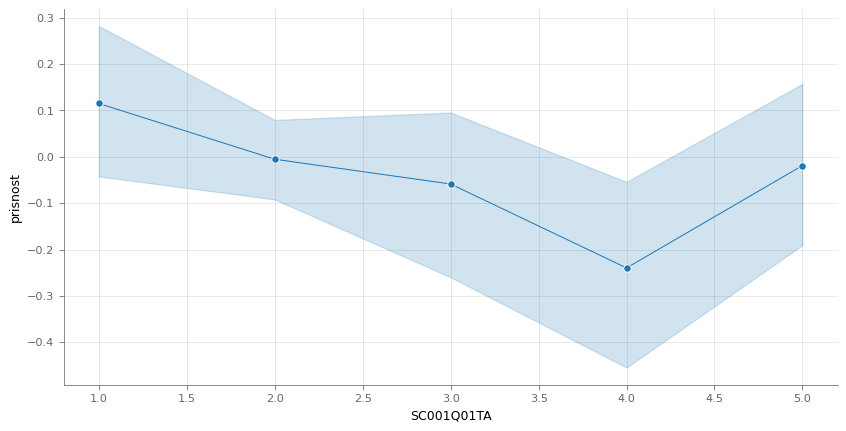

In [455]:
sns.lineplot(x='SC001Q01TA', y='prisnost', data=sch, marker='o')

In [457]:
sch18_meta.variable_value_labels['SC001Q01TA']

{1.0: 'A village, hamlet or rural area (fewer than 3 000 people)',
 2.0: 'A small town (3 000 to about 15 000 people)',
 3.0: 'A town (15 000 to about 100 000 people)',
 4.0: 'A city (100 000 to about 1 000 000 people)',
 5.0: 'A large city (with over 1 000 000 people)',
 95.0: 'Valid Skip',
 97.0: 'Not Applicable',
 98.0: 'Invalid',
 99.0: 'No Response'}

<AxesSubplot:xlabel='prisnost', ylabel='SC001Q01TA'>

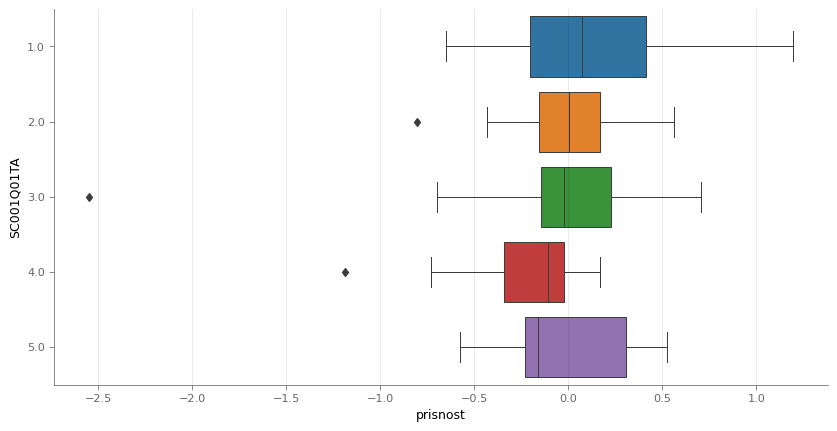

In [461]:
sns.boxplot(y='SC001Q01TA', x='prisnost', data=sch, orient='h')

### Soukromá vs veřejná

In [458]:
sch18_meta.variable_value_labels['SC013Q01TA']

{1.0: 'A public school (Managed by a public education authority, government agency, or governing board)',
 2.0: 'A private school (Managed by a non-government org; e.g. a church, trade union, business, or other private institution.)',
 5.0: 'Valid Skip',
 7.0: 'Not Applicable',
 8.0: 'Invalid',
 9.0: 'No Response'}

<AxesSubplot:xlabel='prisnost', ylabel='SC013Q01TA'>

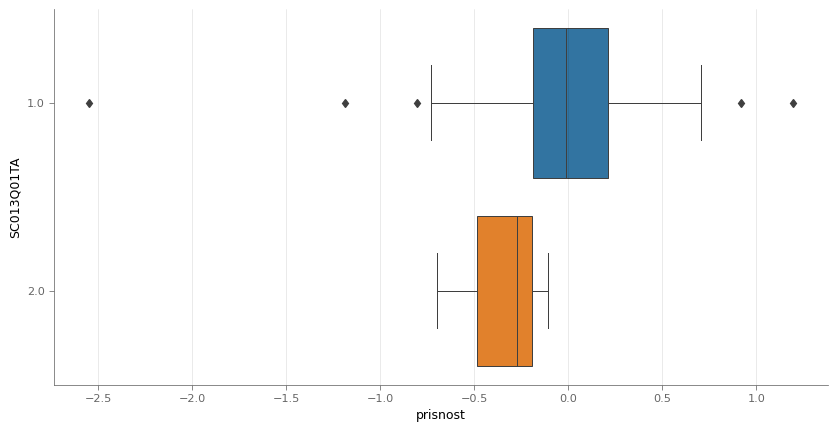

In [462]:
sns.boxplot(y='SC013Q01TA', x='prisnost', data=sch, orient='h')

<AxesSubplot:xlabel='SC013Q01TA', ylabel='prisnost'>

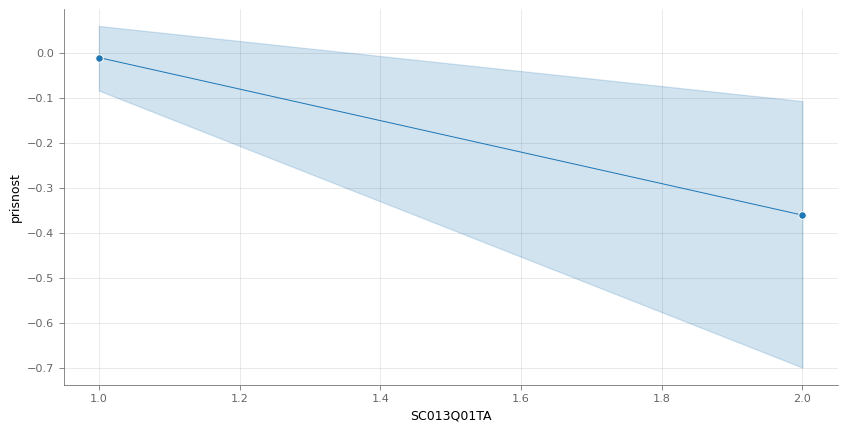

In [459]:
sns.lineplot(x='SC013Q01TA', y='prisnost', data=sch, marker='o')

### Velikost školy

<AxesSubplot:xlabel='SCHSIZE', ylabel='prisnost'>

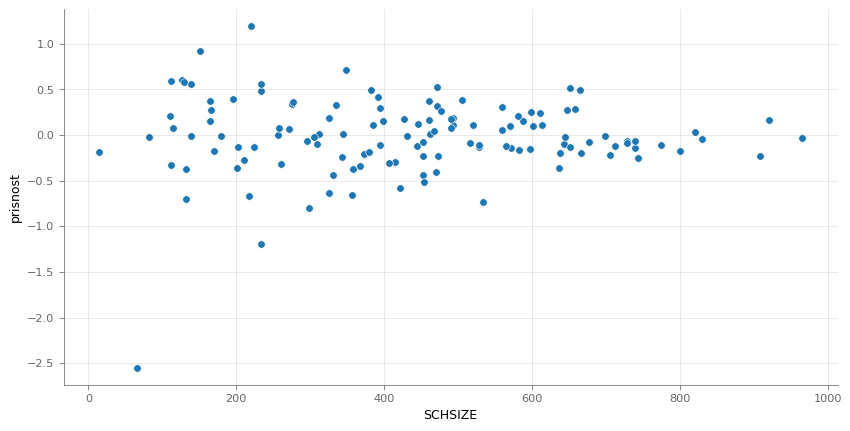

In [463]:
sns.scatterplot(x='SCHSIZE', y='prisnost', data=sch)

In [465]:
sch[['SCHSIZE', 'prisnost']].corr()

,SCHSIZE,prisnost
SCHSIZE,1.000000,0.019058
prisnost,0.019058,1.000000


### K čemu škola hodnocení používá

In [469]:
sch18_meta.variable_value_labels['SC154Q02WA']

{1.0: 'Yes',
 2.0: 'No',
 5.0: 'Valid Skip',
 7.0: 'Not Applicable',
 8.0: 'Invalid',
 9.0: 'No Response'}

In [468]:
sch['SC154Q02WA'].value_counts()

1.0    118
2.0     10
Name: SC154Q02WA, dtype: int64

In [470]:
selcols = [c for c in sch.columns if c.startswith('SC154')]

In [473]:
foo = sch.groupby('prisnost_bin')[selcols + ['W_SCHGRNRABWT']].apply(nanaverage, weights='W_SCHGRNRABWT')

<AxesSubplot:xlabel='prisnost_bin'>

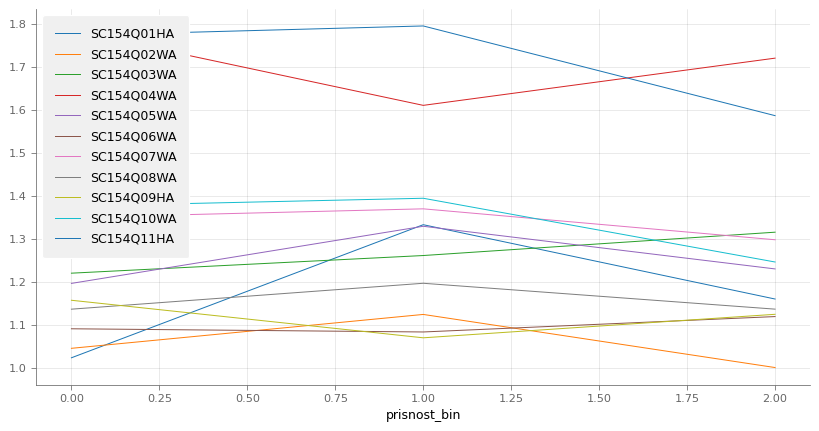

In [474]:
foo.plot()

<AxesSubplot:>

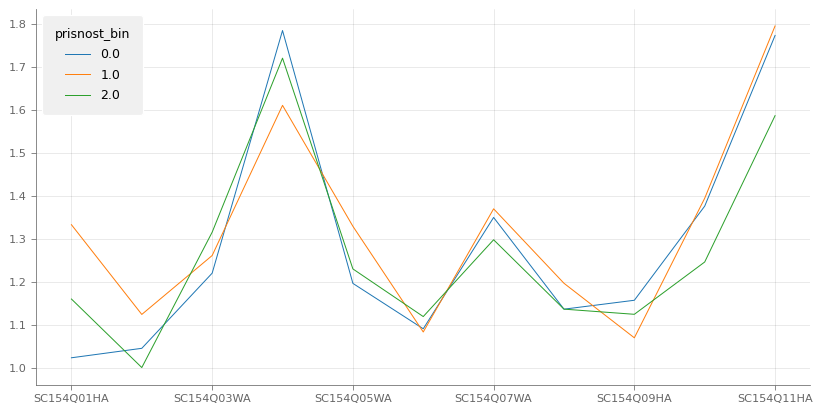

In [477]:
foo.T.plot()

In [476]:
{k: v for k, v in sch18_meta.column_names_to_labels.items() if k in selcols}

{'SC154Q01HA': "School's use of assessments of students: To guide students' learning",
 'SC154Q02WA': "School's use of assessments of students: To inform parents about their child's progress",
 'SC154Q03WA': "School's use of assessments of students: To make decisions about students' retention or promotion",
 'SC154Q04WA': "School's use of assessments of students: To group students for instructional purposes",
 'SC154Q05WA': "School's use of assessments of students: To compare the school to <district or national> performance",
 'SC154Q06WA': "School's use of assessments of students: To monitor the school’s progress from year to year",
 'SC154Q07WA': "School's use of assessments of students: To make judgements about teachers' effectiveness",
 'SC154Q08WA': "School's use of assessments of students: To identify aspects of instruction or the curriculum that could be improved",
 'SC154Q09HA': "School's use of assessments of students: To adapt teaching to the students' needs",
 'SC154Q10WA': 

<AxesSubplot:xlabel='TEACHBEHA', ylabel='prisnost'>

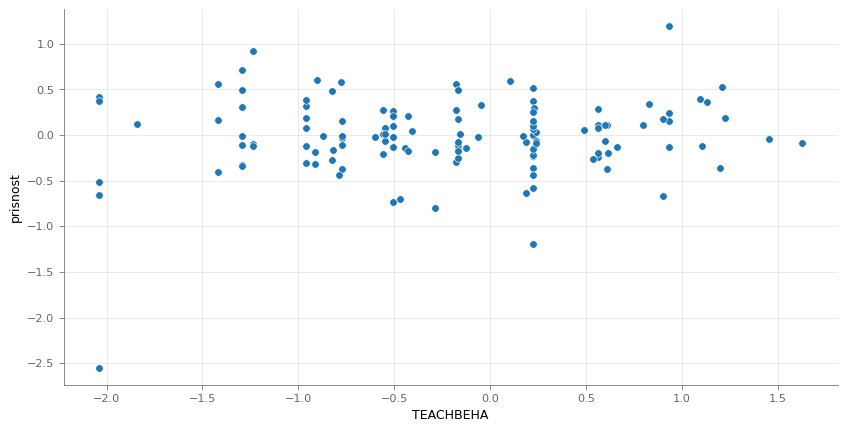

In [483]:
sns.scatterplot(x='TEACHBEHA', y='prisnost', data=sch)

In [450]:
sch18['SC001Q01TA'].value_counts()

3.0    113
2.0    100
4.0     45
5.0     35
1.0     32
Name: SC001Q01TA, dtype: int64

In [449]:
sch18_meta.column_names_to_labels

{'CNTRYID': 'Country Identifier',
 'CNTSCHID': 'Intl. School ID',
 'SC001Q01TA': 'Which of the following definitions best describes the community in which your school is located?',
 'SC013Q01TA': 'Is your school a public or a private school?',
 'SC016Q01TA': 'Percentage of total funding for school year from: Government',
 'SC016Q02TA': 'Percentage of total funding for school year from: Student fees or school charges paid by parents',
 'SC016Q03TA': 'Percentage of total funding for school year from: Benefactors, donations, bequests, sponsorships, parent fundraising',
 'SC016Q04TA': 'Percentage of total funding for school year from: Other',
 'SC017Q01NA': "School's instruction hindered by: A lack of teaching staff.",
 'SC017Q02NA': "School's instruction hindered by: Inadequate or poorly qualified teaching staff.",
 'SC017Q03NA': "School's instruction hindered by: A lack of assisting staff.",
 'SC017Q04NA': "School's instruction hindered by: Inadequate or poorly qualified assisting staff.

## Co dál?

- histogram přísností
- kolik je škol v každé kategorii -> to je trochu mess, není to úplně vyrovnané podle většiny logických metrik...
- přidat sem model pro logit, ať to mám případně po ruce?

In [87]:
for c in df.columns:
    if df[c].dtype == np.float_:
        df.loc[df[c] > 1e300, c] = np.nan

In [84]:
df['BSMJ'] > 1e300

0      False
1      False
2       True
3      False
4      False
       ...  
342    False
343    False
344    False
345    False
346    False
Name: BSMJ, Length: 347, dtype: bool

In [ ]:
df['BSMJ'] = np.where(df['BSMJ'] > )

In [86]:
df.loc[df['BSMJ'] > 1e300, 'BSMJ'] = np.nan

In [78]:
df['BSMJ'].min(), df['BSMJ'].max()

(13.34, 8.98846567431158e+307)

In [81]:
for c in df.columns:
    print(c)

CNTSTUID
CNTSCHID
CNTRYID
STRATUM
STRATUMID_rec
ST001D01T
ST003D02T
ST003D03T
ST004D01T
ST005Q01TA
ST006Q01TA
ST006Q02TA
ST006Q03TA
ST006Q04TA
ST007Q01TA
ST008Q01TA
ST008Q02TA
ST008Q03TA
ST008Q04TA
ST011Q01TA
ST011Q02TA
ST011Q03TA
ST011Q04TA
ST011Q05TA
ST011Q06TA
ST011Q07TA
ST011Q08TA
ST011Q09TA
ST011Q10TA
ST011Q11TA
ST011Q12TA
ST011Q16NA
ST011D17TA
ST011D18TA
ST011D19TA
ST012Q01TA
ST012Q02TA
ST012Q03TA
ST012Q05NA
ST012Q06NA
ST012Q07NA
ST012Q08NA
ST012Q09NA
ST013Q01TA
ST019AQ01T
ST019BQ01T
ST019CQ01T
ST021Q01TA
ST125Q01NA
ST126Q01TA
ST127Q01TA
ST127Q02TA
ST127Q03TA
ST022Q01TA
ST023Q01TA
ST023Q02TA
ST023Q03TA
ST023Q04TA
ST023Q05TA
ST097Q01TA
ST097Q02TA
ST097Q03TA
ST097Q04TA
ST097Q05TA
ST100Q01TA
ST100Q02TA
ST100Q03TA
ST100Q04TA
ST102Q01TA
ST102Q02TA
ST102Q03TA
ST102Q04TA
ST211Q01HA
ST211Q02HA
ST211Q03HA
ST212Q01HA
ST212Q02HA
ST212Q03HA
ST104Q02NA
ST104Q03NA
ST104Q04NA
ST213Q01HA
ST213Q02HA
ST213Q03HA
ST213Q04HA
ST150Q01IA
ST150Q02IA
ST150Q03IA
ST150Q04HA
ST152Q05IA
ST152Q06IA
ST152Q07IA

In [59]:
df['mathz']

0       8.988466e+307
1       8.988466e+307
2       8.988466e+307
3       8.988466e+307
4       8.988466e+307
            ...      
1866    8.988466e+307
1867    8.988466e+307
1868    8.988466e+307
1869    8.988466e+307
1870    8.988466e+307
Name: mathz, Length: 1871, dtype: float64

In [60]:
df['math']

0       8.988466e+307
1       8.988466e+307
2       8.988466e+307
3       8.988466e+307
4       8.988466e+307
            ...      
1866    8.988466e+307
1867    8.988466e+307
1868    8.988466e+307
1869    8.988466e+307
1870    8.988466e+307
Name: math, Length: 1871, dtype: float64

In [61]:
df['ESCSz']

0      -0.840526
1       1.629721
2       0.040614
3       0.221304
4       0.344877
          ...   
1866    0.867546
1867    0.398114
1868    0.630829
1869    1.244813
1870   -0.478296
Name: ESCSz, Length: 1871, dtype: float64

In [17]:
%%stata
qui d
di r(N), r(k)


. qui d

. di r(N), r(k)
1871 753

. 


In [3]:
# cesta k datum
data_root = '/mnt/d/projects/idea/data'

In [4]:
sch18, sch18_meta = pyreadstat.read_sav(f'{data_root}/PISA/2018/CZ/CY07_MSU_SCH_QQQ_FINAL_CZ.sav')
stu18, stu18_meta = pyreadstat.read_sav(f'{data_root}/PISA/2018/CZ/CY07_MSU_STU_QQQ_FINAL_CZ.sav')

In [5]:
df = stu18[(stu18['ST001D01T'] == 9) & (stu18['STRATUMID_rec'] == 1)].copy()

In [6]:
df['ST800C01HA_CZ'] = df['ST800C01HA_CZ'].replace({6: np.nan})
df['ST800C02HA_CZ'] = df['ST800C02HA_CZ'].replace({6: np.nan})
df['ST800C04HA_CZ'] = df['ST800C04HA_CZ'].replace({6: np.nan})
df['ST800C05HA_CZ'] = df['ST800C05HA_CZ'].replace({6: np.nan})
df['ST800C06HA_CZ'] = df['ST800C06HA_CZ'].replace({6: np.nan})

In [7]:
df['MATH_MEAN'] = np.mean(df[[f'PV{i}MATH' for i in range(1,11)]], axis=1)
df['READ_MEAN'] = np.mean(df[[f'PV{i}READ' for i in range(1,11)]], axis=1)

In [8]:
foo = df.dropna(subset=['ESCS'])
dswe = DescrStatsW(foo['ESCS'], weights=foo['W_FSTUWT'])
df['ESCSz'] = (df['ESCS'] - dswe.mean) / dswe.std
df['ESCS_high'] = df['ESCS'] > 0

In [9]:
# ve Statě počítám taky nevážené PV u skórů, pro odhad na tom příliš nezáleží - pokud používám stejné z-skóry při odhadu i predikci
for i in range(1,11):
    df[f'PV{i}MATHz'] = (df[f'PV{i}MATH'] - df[f'PV{i}MATH'].mean()) / df[f'PV{i}MATH'].std()
    df[f'PV{i}READz'] = (df[f'PV{i}READ'] - df[f'PV{i}READ'].mean()) / df[f'PV{i}READ'].std()
    
df['MATH_Z'] = np.mean(df[[f'PV{i}MATHz' for i in range(1,11)]], axis=1)
df['READ_Z'] = np.mean(df[[f'PV{i}READz' for i in range(1,11)]], axis=1)

In [10]:
df['gr_matematika'] = np.where(df['ST800C01HA_CZ'] < 3, df['ST800C01HA_CZ'], np.where(df['ST800C01HA_CZ'] < 6, 8 - df['ST800C01HA_CZ'], np.nan))
df['gr_cestina'] = df['ST800C02HA_CZ']
df['girl'] = np.int_(df['ST004D01T'] == 1)

### Známky ~ skóry

```
-------------------------------------------------------------------------------
gr_matematika | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
--------------+----------------------------------------------------------------
        mathz |  -.5079904   .0270445   -18.78   0.000    -.5615527    -.454428
         girl |  -.3372834   .0500997    -6.73   0.000    -.4358147   -.2387522
        ESCSz |  -.1478415   .0239075    -6.18   0.000    -.1947578   -.1009251
        _cons |   2.703638   .0412585    65.53   0.000      2.62276    2.784516
-------------------------------------------------------------------------------

------------------------------------------------------------------------------
  gr_cestina | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
       readz |  -.3937293   .0248825   -15.82   0.000    -.4425728   -.3448858
        girl |  -.4211505   .0418484   -10.06   0.000    -.5031875   -.3391134
       ESCSz |  -.1541386   .0239628    -6.43   0.000    -.2011054   -.1071717
       _cons |   2.554044   .0439796    58.07   0.000     2.467845    2.640244
------------------------------------------------------------------------------
```

In [11]:
df['MATH_PRED'] = 2.703638 - .3372834 * df['girl'] - .5079904 * df['MATH_Z'] - .1478415 * df['ESCSz']
df['READ_PRED'] = 2.554044 - .4211505 * df['girl'] - .3937293 * df['READ_Z'] - .1541386 * df['ESCSz']

df['MATH_RESID'] = df['gr_matematika'] - df['MATH_PRED']
df['READ_RESID'] = df['gr_cestina'] - df['READ_PRED']

In [12]:
def nanaverage(x, weights=None):    
    if weights is None:
        if len(x.shape) == 1:
            return np.nanmean(x)
        else:
            res = np.nanmean(x, axis=0)
            return pd.Series(res, x.columns) if isinstance(x, pd.DataFrame) else res
    else:
        w = x[weights]
        x = x.drop(columns=[weights])
        mask = np.isnan(x)
        xm = np.ma.masked_array(x, mask=mask)
        if len(x.shape) == 1:
            return np.ma.average(xm, weights=w)
        else:
            res = np.ma.average(xm, weights=w, axis=0)
            return pd.Series(res, x.columns) if isinstance(x, pd.DataFrame) else res            

In [15]:
sch_resid = df.groupby('CNTSCHID')[['MATH_RESID', 'READ_RESID', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT')
sch_wr = pd.merge(sch18[['CNTSCHID', 'W_SCHGRNRABWT']], sch_resid.rename(columns={'MATH_RESID': 'MATH_SCHOOL_RESID', 'READ_RESID': 'READ_SCHOOL_RESID'}).reset_index())

In [16]:
dswm = DescrStatsW(sch_wr['MATH_SCHOOL_RESID'], weights=sch_wr['W_SCHGRNRABWT'])
dswr = DescrStatsW(sch_wr['READ_SCHOOL_RESID'], weights=sch_wr['W_SCHGRNRABWT'])

qsm = dswm.quantile([0.2, 0.4, 0.6, 0.8])
qsr = dswr.quantile([0.2, 0.4, 0.6, 0.8])

sch_wr['MATH_SCHOOL_BIN'] = pd.cut(sch_wr['MATH_SCHOOL_RESID'], [-np.inf] + list(qsm) + [np.inf], labels=False)
sch_wr['READ_SCHOOL_BIN'] = pd.cut(sch_wr['READ_SCHOOL_RESID'], [-np.inf] + list(qsr) + [np.inf], labels=False)

In [17]:
df = pd.merge(df, sch_wr)

<AxesSubplot:xlabel='MATH_SCHOOL_RESID', ylabel='READ_SCHOOL_RESID'>

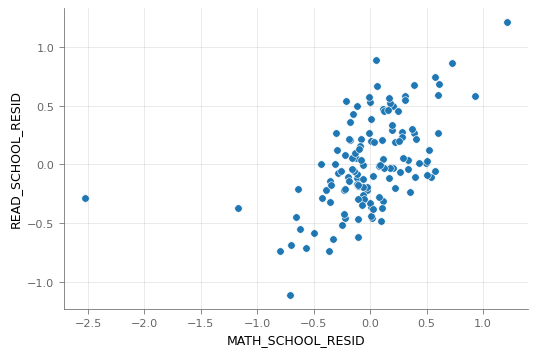

In [18]:
sns.scatterplot(x='MATH_SCHOOL_RESID', y='READ_SCHOOL_RESID', data=sch_wr)

In [19]:
df[['MATH_SCHOOL_RESID', 'READ_SCHOOL_RESID']].corr()

,MATH_SCHOOL_RESID,READ_SCHOOL_RESID
MATH_SCHOOL_RESID,1.000000,0.523566
READ_SCHOOL_RESID,0.523566,1.000000


## Grafy pro studii

Co všechno chci?

Základní deskriptivy
- četnosti známek, kluci vs dívky
- boxplot skóry podle známek (včetně plausible values)
- průměrné skóry podle známek

Pro pět skupin přísnosti známkování:
- četnosti známek
- průměrné skóry podle známek 
- očekávání vystudování VŠ podle známek
- očekávaný status zaměstnání ve 30 podle známek


### Graf č. 1 - boxplot skórů

In [20]:
for i in range(1, 11):
    df[f'math_score_{i}'] = df[f'PV{i}MATH']
dfl = pd.wide_to_long(df, 'math_score', sep='_', j='pv', i=['CNTSTUID'])
df = df.drop(columns=[f'math_score_{i}' for i in range(1, 11)])

In [28]:
plt.rcParams['figure.figsize'] = 10, 5

In [38]:
quantiles = dfl.groupby('gr_matematika')['math_score'].quantile(q=[0.05, 0.25, 0.5, 0.75, 0.95]).unstack()
quantiles.to_csv('output/prisnost-znamkovani/graf1_data.csv', index=False)
quantiles

,0.05,0.25,0.50,0.75,0.95
gr_matematika,,,,,
1.0,414.86920,496.95675,543.3720,589.85000,658.84620
2.0,390.62620,459.56700,507.9785,554.06650,618.60450
3.0,340.12995,407.70575,451.5330,502.11225,569.28295
4.0,311.54170,377.89625,423.9050,472.29375,532.49765
5.0,279.23590,364.91625,405.9275,446.11350,519.09170


In [39]:
dfl['math_score'].quantile(q=[0.05, 0.25, 0.5, 0.75, 0.95])

0.05    344.85490
0.25    423.99825
0.50    480.67250
0.75    537.23925
0.95    610.71985
Name: math_score, dtype: float64

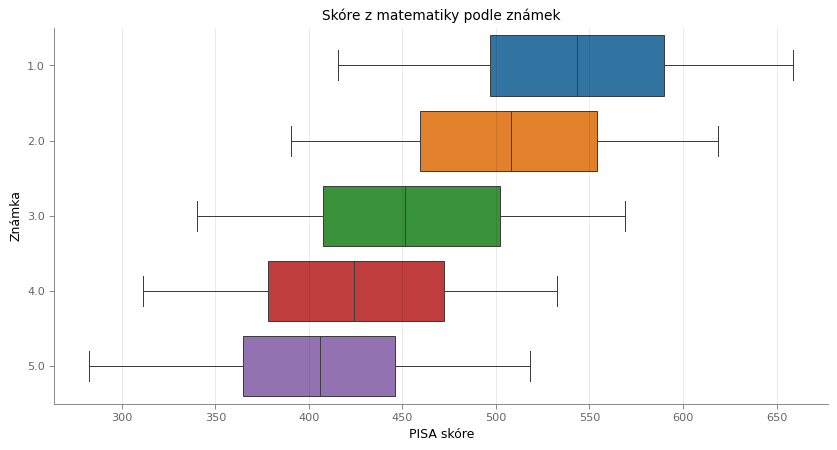

In [41]:
ax = sns.boxplot(y='gr_matematika', x='math_score', data=dfl, orient='h', whis=[5, 95], showfliers=False)
ax.set_title('Skóre z matematiky podle známek')
ax.set(xlabel='PISA skóre', ylabel='Známka')
ax.get_figure().savefig('output/prisnost-znamkovani/graf1.png')
ax.get_figure().savefig('output/prisnost-znamkovani/graf1.pdf')

[Text(0.5, 0, 'PISA skóre'), Text(0, 0.5, 'Známka')]

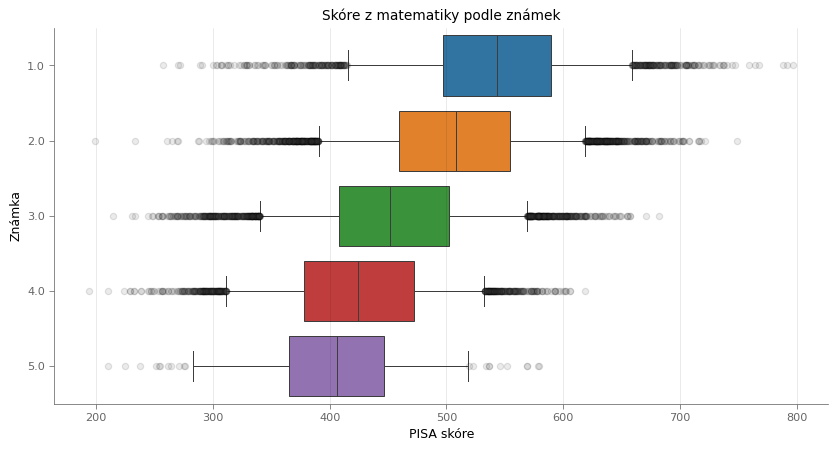

In [35]:
ax = sns.boxplot(y='gr_matematika', x='math_score', data=dfl, orient='h', whis=[5, 95], flierprops={'markeredgecolor': 'black', 'marker': 'o', 'alpha': 0.1})
ax.set_title('Skóre z matematiky podle známek')
ax.set(xlabel='PISA skóre', ylabel='Známka')

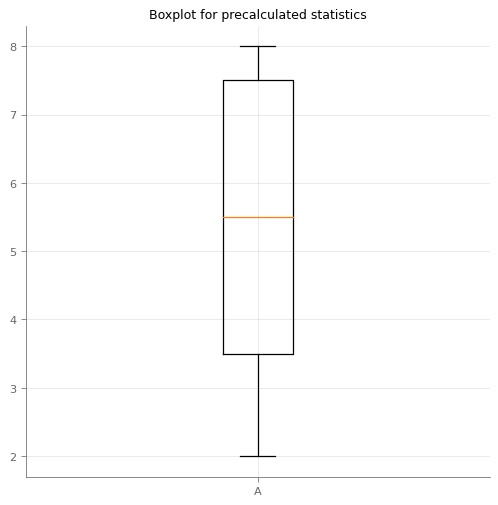

In [40]:

stats = [{
    "label": 'A',  # not required
    "mean":  5,  # not required
    "med": 5.5,
    "q1": 3.5,
    "q3": 7.5,
    # "cilo": 5.3 # not required
    # "cihi": 5.7 # not required
    "whislo": 2.0,  # required
    "whishi": 8.0,  # required
    "fliers": []  # required if showfliers=True
    }]

fs = 10  # fontsize

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), sharey=True)
axes.bxp(stats)
axes.set_title('Boxplot for precalculated statistics', fontsize=fs)
plt.show()

Text(0.5, 1.0, 'Četnosti známek z matematiky')

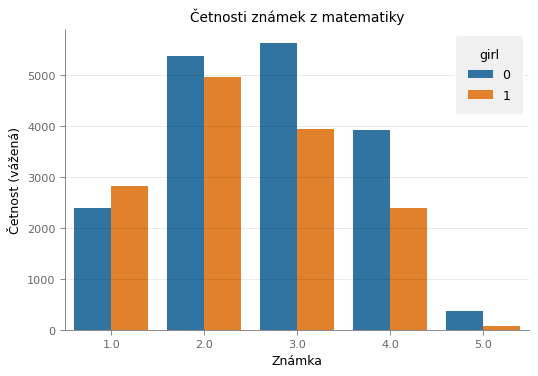

In [22]:
foo = df.groupby(['gr_matematika', 'girl'])['W_FSTUWT'].sum().reset_index()
ax = sns.barplot(x='gr_matematika', y='W_FSTUWT', hue='girl', data=foo)
ax.set(xlabel='Známka', ylabel='Četnost (vážená)')
ax.set_title('Četnosti známek z matematiky')

Text(0.5, 1.0, 'Průměrné testové skóry v matematice podle známek')

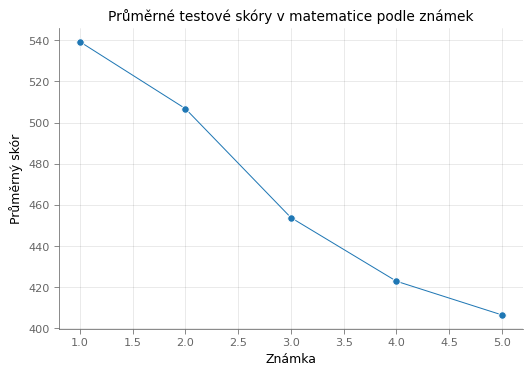

In [25]:
foo = df.groupby('gr_matematika')[['MATH_MEAN', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
ax = sns.lineplot(x='gr_matematika', y='MATH_MEAN', data=foo, marker='o')
ax.set(xlabel='Známka', ylabel='Průměrný skór')
ax.set_title('Průměrné testové skóry v matematice podle známek')

In [26]:
foo

,gr_matematika,MATH_MEAN
0,1.0,539.261364
1,2.0,506.757413
2,3.0,453.829567
3,4.0,422.936598
4,5.0,406.562235


[Text(0.5, 0, 'PISA skóre'),
 Text(0, 0.5, 'Přísnost (0 = nejméně přísné, 4 = nejvíce přísné)')]

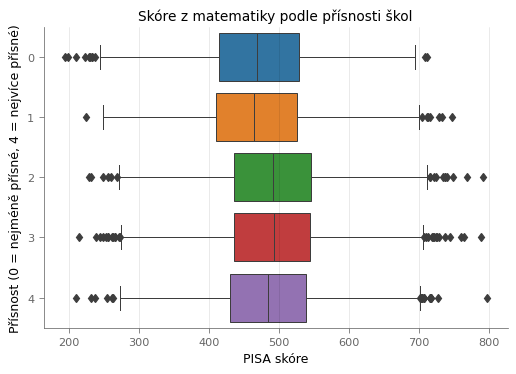

In [54]:
ax = sns.boxplot(y='MATH_SCHOOL_BIN', x='math_score', data=dfl, orient='h')
ax.set_title('Skóre z matematiky podle přísnosti škol')
ax.set(xlabel='PISA skóre', ylabel='Přísnost (0 = nejméně přísné, 4 = nejvíce přísné)')

[Text(0.5, 0, 'Známka'),
 Text(0, 0.5, 'Průměrný skór'),
 Text(0.5, 1.0, 'Průměrné testové skóry z matematiky podle známek a přísnosti škol')]

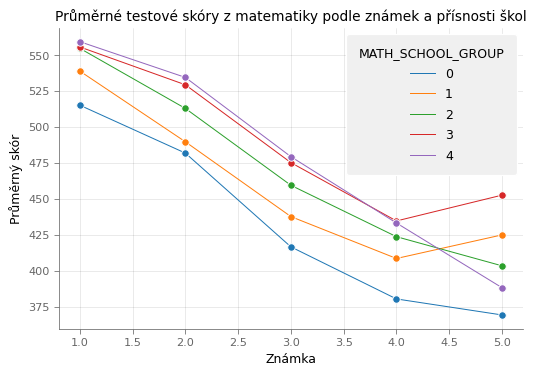

In [56]:
# df.groupby(['gr_matematika', 'SCH_BIN', 'ST225Q06HA'])['CNTSTUID'].count()
foo = df.groupby(['gr_matematika', 'MATH_SCHOOL_BIN'])[['MATH_MEAN', 'ST225Q06HA', 'BSMJ', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
foo['MATH_SCHOOL_GROUP'] = pd.Categorical(foo['MATH_SCHOOL_BIN'])
ax = sns.lineplot(x='gr_matematika', y='MATH_MEAN', data=foo, hue='MATH_SCHOOL_GROUP', marker='o')
ax.set(xlabel='Známka', ylabel='Průměrný skór', title='Průměrné testové skóry z matematiky podle známek a přísnosti škol')

[Text(0.5, 1.0, 'Podíl žáků, který očekává vystudování VŠ'),
 Text(0.5, 0, 'Známka'),
 Text(0, 0.5, 'Podíl žáků')]

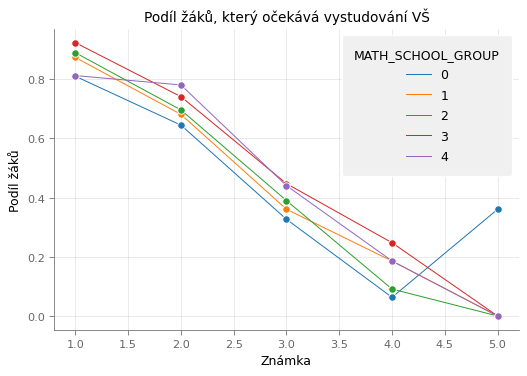

In [57]:
ax = sns.lineplot(x='gr_matematika', y='ST225Q06HA', data=foo, hue='MATH_SCHOOL_GROUP', marker='o')
ax.set(title='Podíl žáků, který očekává vystudování VŠ', xlabel='Známka', ylabel='Podíl žáků')

[Text(0.5, 1.0, 'Status očekávaného zaměstnání ve 30 letech'),
 Text(0.5, 0, 'Známka'),
 Text(0, 0.5, 'Index BSMJ')]

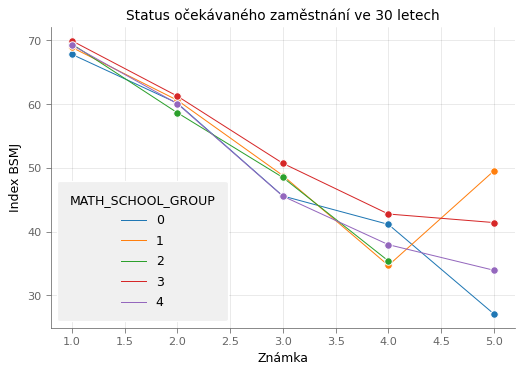

In [58]:
ax = sns.lineplot(x='gr_matematika', y='BSMJ', data=foo, hue='MATH_SCHOOL_GROUP', marker='o')
ax.set(title='Status očekávaného zaměstnání ve 30 letech', xlabel='Známka', ylabel='Index BSMJ')

[Text(0.5, 0, 'Známka'), Text(0, 0.5, 'Relativní četnost')]

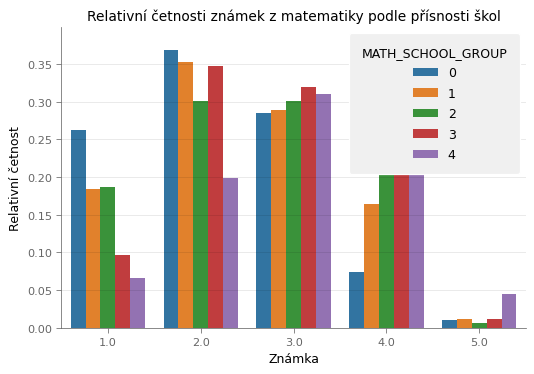

In [55]:
foo = df.groupby(['gr_matematika', 'MATH_SCHOOL_BIN'])['W_FSTUWT'].sum().reset_index()
foo = pd.merge(foo, foo.groupby('MATH_SCHOOL_BIN')['W_FSTUWT'].sum().rename('W_FSTUWT_TOTAL').reset_index())
foo['MATH_SCHOOL_GROUP'] = pd.Categorical(foo['MATH_SCHOOL_BIN'])
foo['rel_weight'] = foo['W_FSTUWT'] / foo['W_FSTUWT_TOTAL']
ax = sns.barplot(x='gr_matematika', y='rel_weight', hue='MATH_SCHOOL_GROUP', data=foo)
ax.set_title('Relativní četnosti známek z matematiky podle přísnosti škol')
ax.set(xlabel='Známka', ylabel='Relativní četnost')

## Vypadá to tak i v češtině?

In [47]:
for i in range(1, 11):
    df[f'read_score_{i}'] = df[f'PV{i}READ']
dfl = pd.wide_to_long(df, 'read_score', sep='_', j='pv', i=['CNTSTUID'])
df = df.drop(columns=[f'read_score_{i}' for i in range(1, 11)])

[Text(0.5, 0, 'PISA skóre'), Text(0, 0.5, 'Přísnost')]

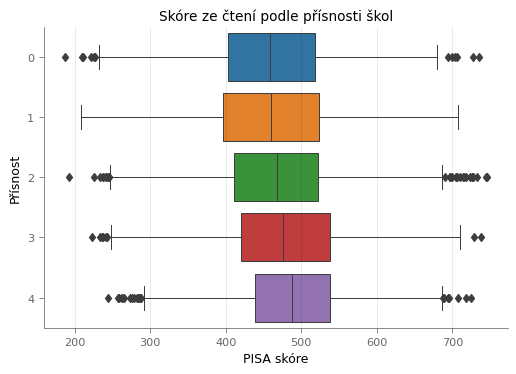

In [49]:
ax = sns.boxplot(y='READ_SCHOOL_BIN', x='read_score', data=dfl, orient='h')
ax.set_title('Skóre ze čtení podle přísnosti škol')
ax.set(xlabel='PISA skóre', ylabel='Přísnost')

<AxesSubplot:xlabel='gr_cestina', ylabel='W_FSTUWT'>

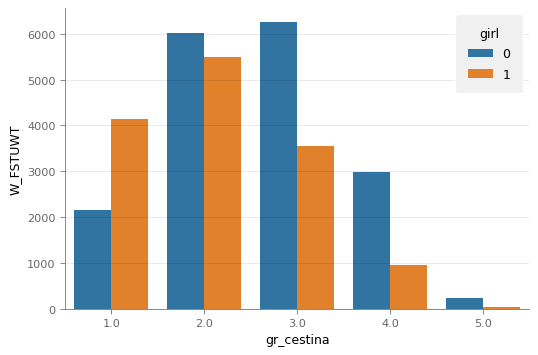

In [40]:
foo = df.groupby(['gr_cestina', 'girl'])['W_FSTUWT'].sum().reset_index()
sns.barplot(x='gr_cestina', y='W_FSTUWT', hue='girl', data=foo)

<AxesSubplot:xlabel='gr_cestina', ylabel='READ_MEAN'>

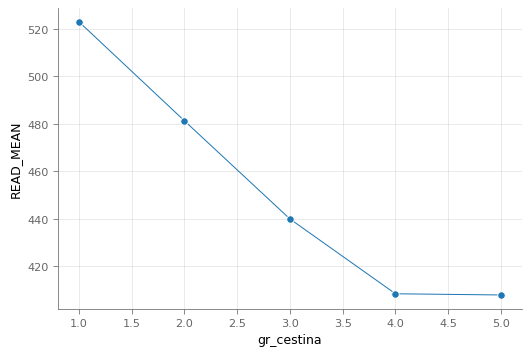

In [41]:
foo = df.groupby('gr_cestina')[['READ_MEAN', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
sns.lineplot(x='gr_cestina', y='READ_MEAN', data=foo, marker='o')

<AxesSubplot:xlabel='gr_cestina', ylabel='READ_MEAN'>

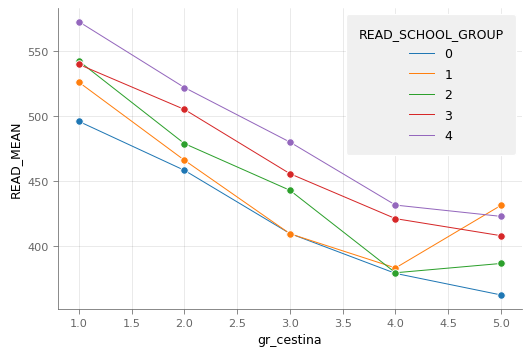

In [42]:
# df.groupby(['gr_matematika', 'SCH_BIN', 'ST225Q06HA'])['CNTSTUID'].count()
foo = df.groupby(['gr_cestina', 'READ_SCHOOL_BIN'])[['READ_MEAN', 'ST225Q06HA', 'BSMJ', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
foo['READ_SCHOOL_GROUP'] = pd.Categorical(foo['READ_SCHOOL_BIN'])
sns.lineplot(x='gr_cestina', y='READ_MEAN', data=foo, hue='READ_SCHOOL_GROUP', marker='o')

<AxesSubplot:xlabel='gr_cestina', ylabel='ST225Q06HA'>

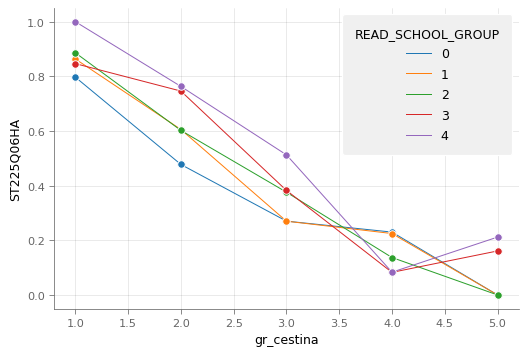

In [43]:
sns.lineplot(x='gr_cestina', y='ST225Q06HA', data=foo, hue='READ_SCHOOL_GROUP', marker='o')

<AxesSubplot:xlabel='gr_cestina', ylabel='BSMJ'>

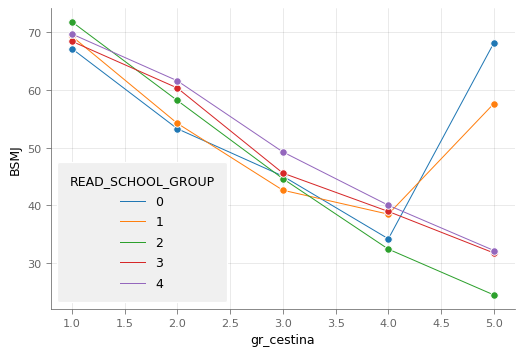

In [44]:
sns.lineplot(x='gr_cestina', y='BSMJ', data=foo, hue='READ_SCHOOL_GROUP', marker='o')

<AxesSubplot:xlabel='gr_cestina', ylabel='rel_weight'>

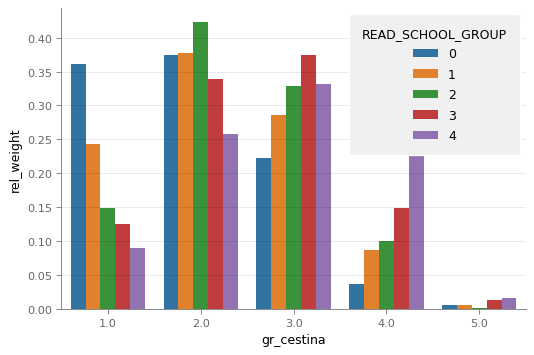

In [45]:
foo = df.groupby(['gr_cestina', 'READ_SCHOOL_BIN'])['W_FSTUWT'].sum().reset_index()
foo = pd.merge(foo, foo.groupby('READ_SCHOOL_BIN')['W_FSTUWT'].sum().rename('W_FSTUWT_TOTAL').reset_index())
foo['READ_SCHOOL_GROUP'] = pd.Categorical(foo['READ_SCHOOL_BIN'])
foo['rel_weight'] = foo['W_FSTUWT'] / foo['W_FSTUWT_TOTAL']
sns.barplot(x='gr_cestina', y='rel_weight', hue='READ_SCHOOL_GROUP', data=foo)

## Science

In [61]:
df = df[(np.isfinite(df['ST800C04HA_CZ'])) & (df['ST800C04HA_CZ'] <= 5) & (np.isfinite(df['ST800C05HA_CZ'])) & (df['ST800C05HA_CZ'] <= 5) & (np.isfinite(df['ST800C06HA_CZ'])) & (df['ST800C06HA_CZ'] <= 5)].copy()

In [62]:
df.shape

(1869, 768)

In [64]:
df['SCIE_MEAN'] = np.mean(df[[f'PV{i}SCIE' for i in range(1,11)]], axis=1)

<AxesSubplot:xlabel='ST800C04HA_CZ', ylabel='SCIE_MEAN'>

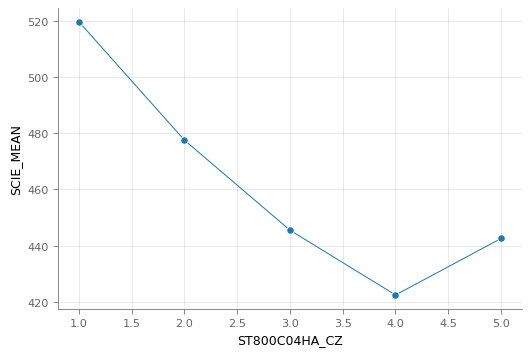

In [65]:
# FYZIKA
foo = df.groupby('ST800C04HA_CZ')[['SCIE_MEAN', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
sns.lineplot(x='ST800C04HA_CZ', y='SCIE_MEAN', data=foo, marker='o')

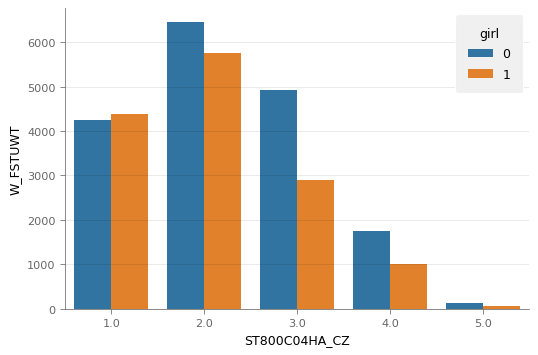

In [66]:
foo = df.groupby(['ST800C04HA_CZ', 'girl'])['W_FSTUWT'].sum().reset_index()
ax = sns.barplot(x='ST800C04HA_CZ', y='W_FSTUWT', hue='girl', data=foo)

<AxesSubplot:xlabel='ST800C05HA_CZ', ylabel='SCIE_MEAN'>

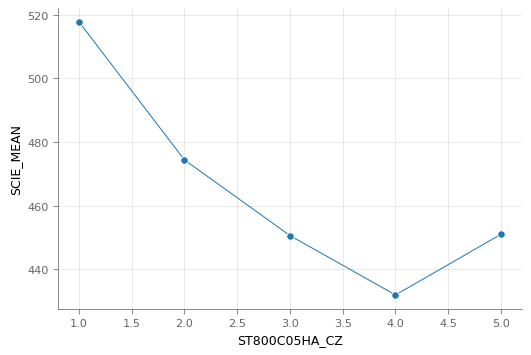

In [67]:
# CHEMIE
foo = df.groupby('ST800C05HA_CZ')[['SCIE_MEAN', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
sns.lineplot(x='ST800C05HA_CZ', y='SCIE_MEAN', data=foo, marker='o')

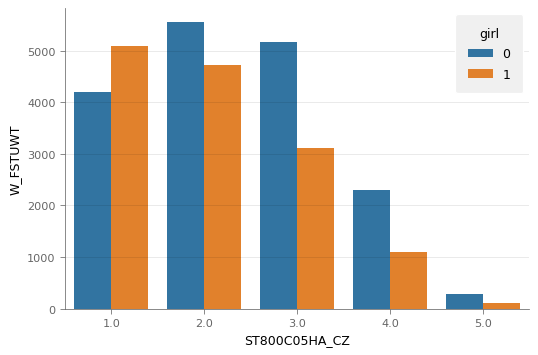

In [68]:
foo = df.groupby(['ST800C05HA_CZ', 'girl'])['W_FSTUWT'].sum().reset_index()
ax = sns.barplot(x='ST800C05HA_CZ', y='W_FSTUWT', hue='girl', data=foo)

<AxesSubplot:xlabel='ST800C06HA_CZ', ylabel='SCIE_MEAN'>

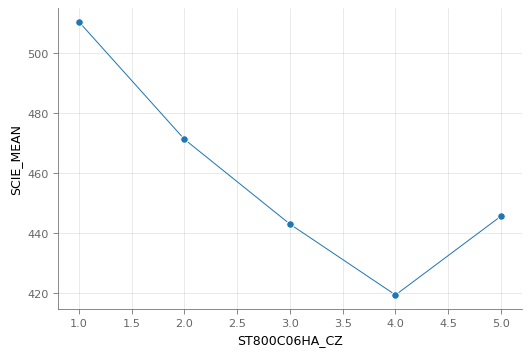

In [69]:
# PŘÍRODOVĚDA
foo = df.groupby('ST800C06HA_CZ')[['SCIE_MEAN', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
sns.lineplot(x='ST800C06HA_CZ', y='SCIE_MEAN', data=foo, marker='o')

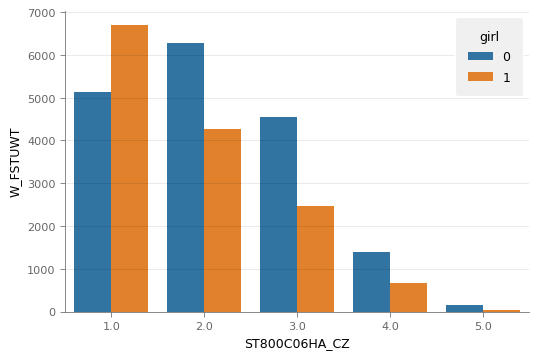

In [70]:
foo = df.groupby(['ST800C06HA_CZ', 'girl'])['W_FSTUWT'].sum().reset_index()
ax = sns.barplot(x='ST800C06HA_CZ', y='W_FSTUWT', hue='girl', data=foo)

In [71]:
df['gr_science'] = (df['ST800C04HA_CZ'] + df['ST800C05HA_CZ'] + df['ST800C06HA_CZ']) / 3

```
------------------------------------------------------------------------------
  gr_science | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
       sciez |  -.3404235   .0230278   -14.78   0.000    -.3859765   -.2948705
        girl |  -.3406425   .0405931    -8.39   0.000    -.4203461   -.2609389
       ESCSz |  -.1795881   .0217758    -8.25   0.000    -.2222751   -.1369011
       _cons |    2.27221   .0364118    62.40   0.000     2.200823    2.343596
------------------------------------------------------------------------------
```

In [72]:
for i in range(1,11):
    df[f'PV{i}SCIEz'] = (df[f'PV{i}SCIE'] - df[f'PV{i}SCIE'].mean()) / df[f'PV{i}SCIE'].std()
df['SCIE_Z'] = np.mean(df[[f'PV{i}SCIEz' for i in range(1,11)]], axis=1)

In [73]:
df['SCIE_PRED'] = 2.27221 - .3406425 * df['girl'] - .3404235 * df['SCIE_Z'] - .1795881 * df['ESCSz']
df['SCIE_RESID'] = df['gr_science'] - df['SCIE_PRED']

In [74]:
sch_resid = df.groupby('CNTSCHID')[['SCIE_RESID', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT')
sch_wr = pd.merge(sch18[['CNTSCHID', 'W_SCHGRNRABWT']], sch_resid.rename(columns={'SCIE_RESID': 'SCIE_SCHOOL_RESID'}).reset_index())

dsws = DescrStatsW(sch_wr['SCIE_SCHOOL_RESID'], weights=sch_wr['W_SCHGRNRABWT'])
qss = dsws.quantile([0.2, 0.4, 0.6, 0.8])
sch_wr['SCIE_SCHOOL_BIN'] = pd.cut(sch_wr['SCIE_SCHOOL_RESID'], [-np.inf] + list(qss) + [np.inf], labels=False)

In [75]:
df = pd.merge(df, sch_wr.drop(columns=['W_SCHGRNRABWT']))

Text(0.5, 1.0, 'Průměrné testové skóry v science podle známek')

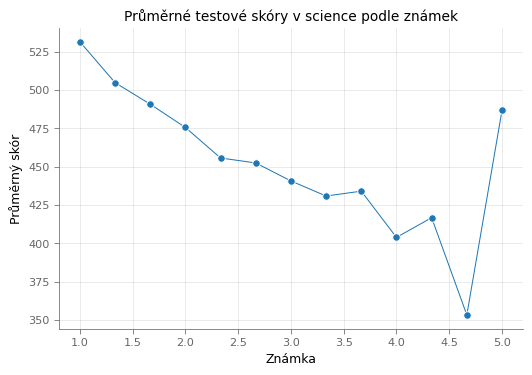

In [76]:
foo = df.groupby('gr_science')[['SCIE_MEAN', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
ax = sns.lineplot(x='gr_science', y='SCIE_MEAN', data=foo, marker='o')
ax.set(xlabel='Známka', ylabel='Průměrný skór')
ax.set_title('Průměrné testové skóry v science podle známek')

In [77]:
for i in range(1, 11):
    df[f'scie_score_{i}'] = df[f'PV{i}SCIE']
dfl = pd.wide_to_long(df, 'scie_score', sep='_', j='pv', i=['CNTSTUID'])
df = df.drop(columns=[f'scie_score_{i}' for i in range(1, 11)])

[Text(0.5, 0, 'PISA skóre'),
 Text(0, 0.5, 'Přísnost (0 = nejméně přísné, 4 = nejvíce přísné)')]

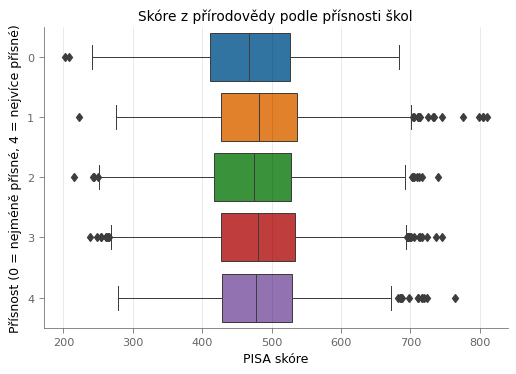

In [78]:
ax = sns.boxplot(y='SCIE_SCHOOL_BIN', x='scie_score', data=dfl, orient='h')
ax.set_title('Skóre z přírodovědy podle přísnosti škol')
ax.set(xlabel='PISA skóre', ylabel='Přísnost (0 = nejméně přísné, 4 = nejvíce přísné)')

Text(0.5, 1.0, 'Četnosti známek ze science')

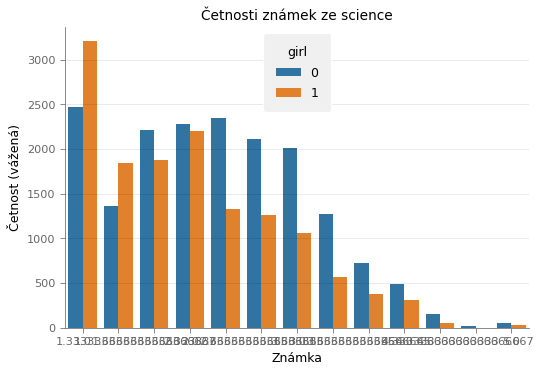

In [79]:
foo = df.groupby(['gr_science', 'girl'])['W_FSTUWT'].sum().reset_index()
ax = sns.barplot(x='gr_science', y='W_FSTUWT', hue='girl', data=foo)
ax.set(xlabel='Známka', ylabel='Četnost (vážená)')
ax.set_title('Četnosti známek ze science')

[Text(0.5, 0, 'Známka'),
 Text(0, 0.5, 'Průměrný skór'),
 Text(0.5, 1.0, 'Průměrné testové skóry ze science podle známek a přísnosti škol')]

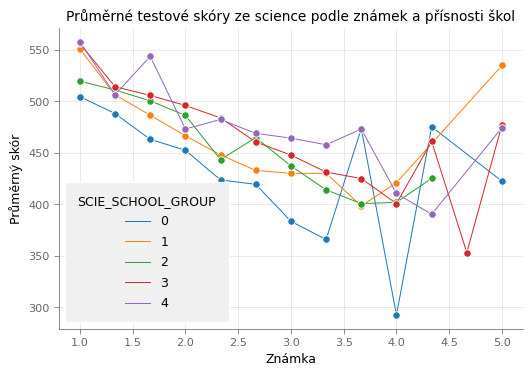

In [80]:
# df.groupby(['gr_matematika', 'SCH_BIN', 'ST225Q06HA'])['CNTSTUID'].count()
foo = df.groupby(['gr_science', 'SCIE_SCHOOL_BIN'])[['SCIE_MEAN', 'ST225Q06HA', 'BSMJ', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
foo['SCIE_SCHOOL_GROUP'] = pd.Categorical(foo['SCIE_SCHOOL_BIN'])
ax = sns.lineplot(x='gr_science', y='SCIE_MEAN', data=foo, hue='SCIE_SCHOOL_GROUP', marker='o')
ax.set(xlabel='Známka', ylabel='Průměrný skór', title='Průměrné testové skóry ze science podle známek a přísnosti škol')

[Text(0.5, 1.0, 'Podíl žáků, který očekává vystudování VŠ'),
 Text(0.5, 0, 'Známka'),
 Text(0, 0.5, 'Podíl žáků')]

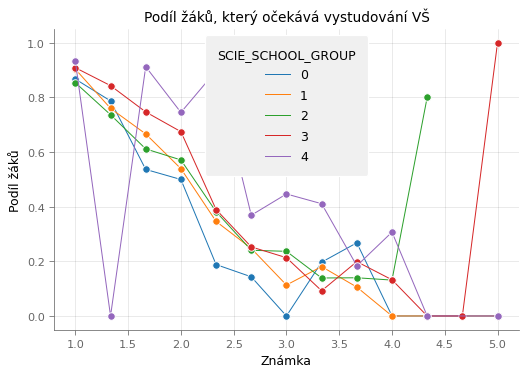

In [81]:
ax = sns.lineplot(x='gr_science', y='ST225Q06HA', data=foo, hue='SCIE_SCHOOL_GROUP', marker='o')
ax.set(title='Podíl žáků, který očekává vystudování VŠ', xlabel='Známka', ylabel='Podíl žáků')

[Text(0.5, 1.0, 'Status očekávaného zaměstnání ve 30 letech'),
 Text(0.5, 0, 'Známka'),
 Text(0, 0.5, 'Index BSMJ')]

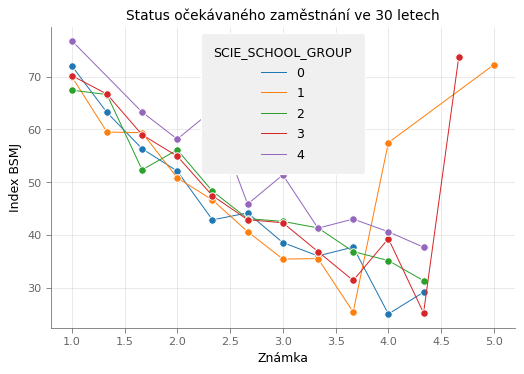

In [82]:
ax = sns.lineplot(x='gr_science', y='BSMJ', data=foo, hue='SCIE_SCHOOL_GROUP', marker='o')
ax.set(title='Status očekávaného zaměstnání ve 30 letech', xlabel='Známka', ylabel='Index BSMJ')

In [83]:
df['gr_science_int'] = np.round(df['gr_science'])

Text(0.5, 1.0, 'Průměrné testové skóry v science podle známek')

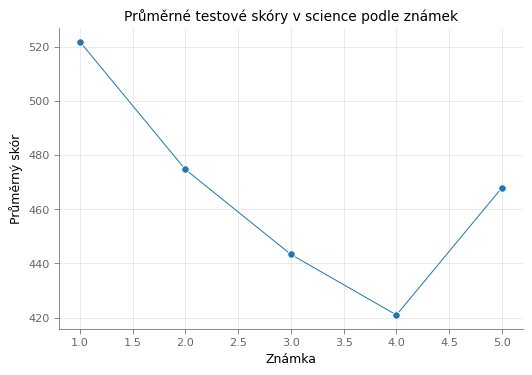

In [84]:
foo = df.groupby('gr_science_int')[['SCIE_MEAN', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
ax = sns.lineplot(x='gr_science_int', y='SCIE_MEAN', data=foo, marker='o')
ax.set(xlabel='Známka', ylabel='Průměrný skór')
ax.set_title('Průměrné testové skóry v science podle známek')

Text(0.5, 1.0, 'Četnosti známek ze science')

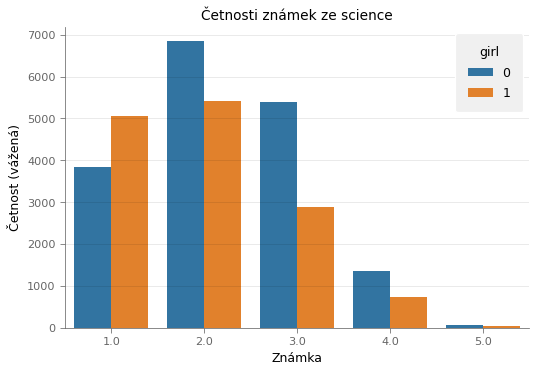

In [85]:
foo = df.groupby(['gr_science_int', 'girl'])['W_FSTUWT'].sum().reset_index()
ax = sns.barplot(x='gr_science_int', y='W_FSTUWT', hue='girl', data=foo)
ax.set(xlabel='Známka', ylabel='Četnost (vážená)')
ax.set_title('Četnosti známek ze science')

[Text(0.5, 0, 'Známka'),
 Text(0, 0.5, 'Průměrný skór'),
 Text(0.5, 1.0, 'Průměrné testové skóry ze science podle známek a přísnosti škol')]

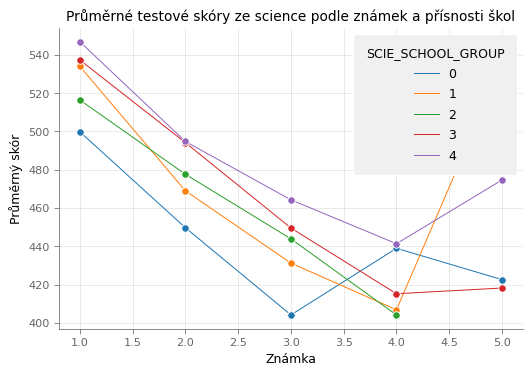

In [86]:
# df.groupby(['gr_matematika', 'SCH_BIN', 'ST225Q06HA'])['CNTSTUID'].count()
foo = df.groupby(['gr_science_int', 'SCIE_SCHOOL_BIN'])[['SCIE_MEAN', 'ST225Q06HA', 'BSMJ', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
foo['SCIE_SCHOOL_GROUP'] = pd.Categorical(foo['SCIE_SCHOOL_BIN'])
ax = sns.lineplot(x='gr_science_int', y='SCIE_MEAN', data=foo, hue='SCIE_SCHOOL_GROUP', marker='o')
ax.set(xlabel='Známka', ylabel='Průměrný skór', title='Průměrné testové skóry ze science podle známek a přísnosti škol')

[Text(0.5, 1.0, 'Podíl žáků, který očekává vystudování VŠ'),
 Text(0.5, 0, 'Známka'),
 Text(0, 0.5, 'Podíl žáků')]

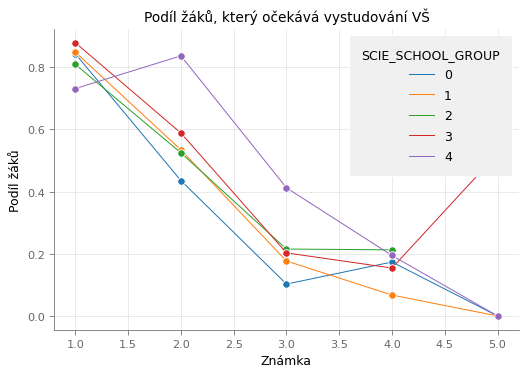

In [87]:
ax = sns.lineplot(x='gr_science_int', y='ST225Q06HA', data=foo, hue='SCIE_SCHOOL_GROUP', marker='o')
ax.set(title='Podíl žáků, který očekává vystudování VŠ', xlabel='Známka', ylabel='Podíl žáků')

[Text(0.5, 1.0, 'Status očekávaného zaměstnání ve 30 letech'),
 Text(0.5, 0, 'Známka'),
 Text(0, 0.5, 'Index BSMJ')]

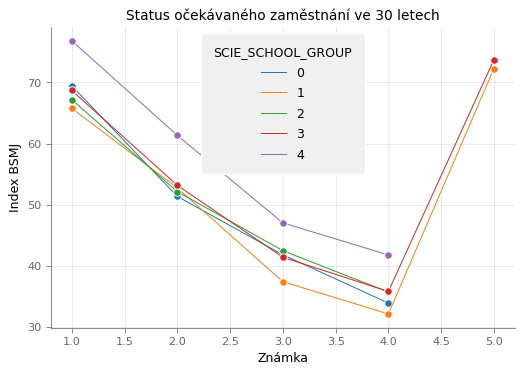

In [88]:
ax = sns.lineplot(x='gr_science_int', y='BSMJ', data=foo, hue='SCIE_SCHOOL_GROUP', marker='o')
ax.set(title='Status očekávaného zaměstnání ve 30 letech', xlabel='Známka', ylabel='Index BSMJ')

## LHS vs RHS?

Znovu vidím rozdíly podle toho, jestli dám známky na RHS nebo LHS -> gender bias in grading depends on it. To už jsem ale řešil při paperu, ne? Co byl tehdy přesně ten důvod?

In [41]:
df.shape

(1878, 738)

<AxesSubplot:xlabel='gr_matematika', ylabel='MATH_MEAN'>

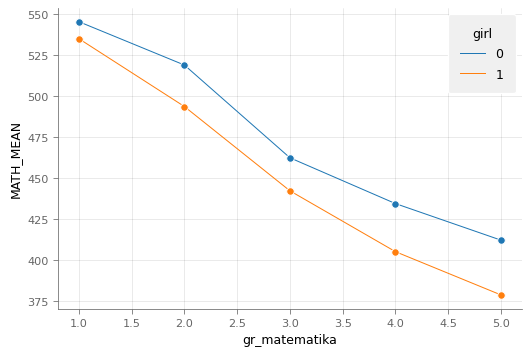

In [45]:
foo = df.groupby(['gr_matematika', 'girl'])[['MATH_MEAN', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
sns.lineplot(x='gr_matematika', y='MATH_MEAN', data=foo, hue='girl', marker='o')

<AxesSubplot:xlabel='gr_cestina', ylabel='READ_MEAN'>

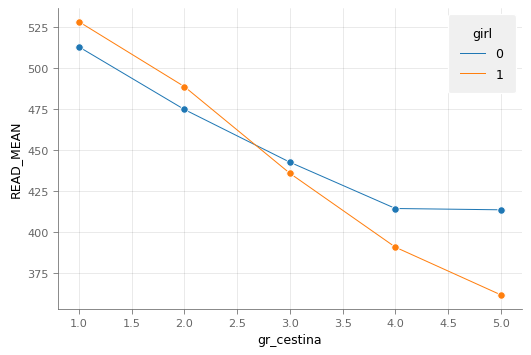

In [46]:
foo = df.groupby(['gr_cestina', 'girl'])[['READ_MEAN', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
sns.lineplot(x='gr_cestina', y='READ_MEAN', data=foo, hue='girl', marker='o')

In [59]:
foo = df.dropna(subset=['ESCS'])
dswe = DescrStatsW(foo['ESCS'], weights=foo['W_FSTUWT'])
df['ESCSz'] = (df['ESCS'] - dswe.mean) / dswe.std
df['ESCS_high'] = df['ESCS'] > 0

In [57]:
dswm = DescrStatsW(df['MATH_MEAN'], weights=df['W_FSTUWT'])
dswr = DescrStatsW(df['READ_MEAN'], weights=df['W_FSTUWT'])

qs = [i / 10 for i in range(1, 10)]
qsm = dswm.quantile(qs)
qsr = dswr.quantile(qs)

df['MATH_BIN'] = pd.cut(df['MATH_MEAN'], [-np.inf] + list(qsm) + [np.inf], labels=False)
df['READ_BIN'] = pd.cut(df['READ_MEAN'], [-np.inf] + list(qsr) + [np.inf], labels=False)

<AxesSubplot:xlabel='MATH_MEAN', ylabel='gr_matematika'>

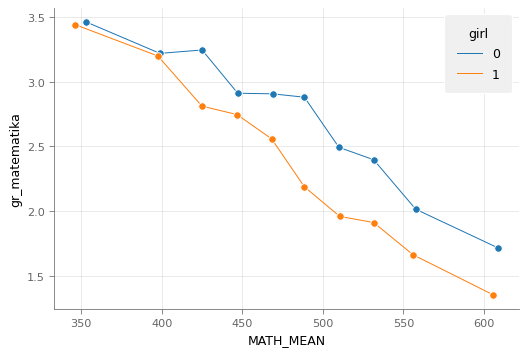

In [58]:
foo = df.groupby(['MATH_BIN', 'girl'])[['MATH_MEAN', 'gr_matematika', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
sns.lineplot(x='MATH_MEAN', y='gr_matematika', data=foo, hue='girl', marker='o')

<AxesSubplot:xlabel='READ_MEAN', ylabel='gr_cestina'>

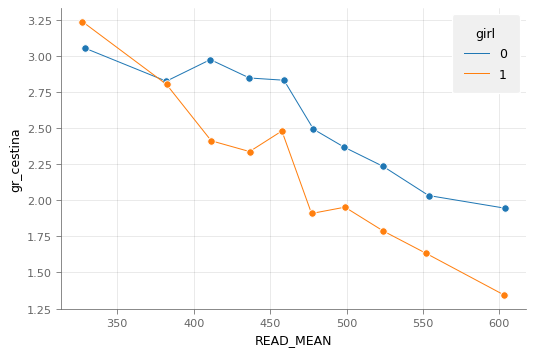

In [60]:
foo = df.groupby(['READ_BIN', 'girl'])[['READ_MEAN', 'gr_cestina', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
sns.lineplot(x='READ_MEAN', y='gr_cestina', data=foo, hue='girl', marker='o')

<AxesSubplot:xlabel='MATH_MEAN', ylabel='gr_matematika'>

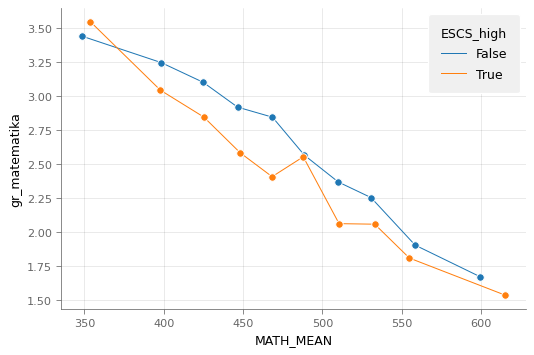

In [61]:
foo = df.groupby(['MATH_BIN', 'ESCS_high'])[['MATH_MEAN', 'gr_matematika', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
sns.lineplot(x='MATH_MEAN', y='gr_matematika', data=foo, hue='ESCS_high', marker='o')

<AxesSubplot:xlabel='READ_MEAN', ylabel='gr_cestina'>

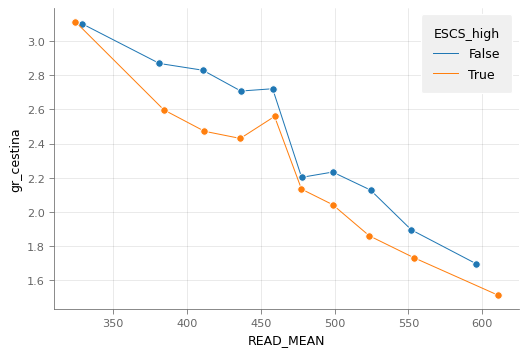

In [62]:
foo = df.groupby(['READ_BIN', 'ESCS_high'])[['READ_MEAN', 'gr_cestina', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
sns.lineplot(x='READ_MEAN', y='gr_cestina', data=foo, hue='ESCS_high', marker='o')